# Notebook for generating analysis and panels in Figure 8


In [2]:
%pylab
%matplotlib inline
%reload_ext autoreload

import pandas as pd
import sys
import seaborn as sns
sys.path.append('../../src')
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('..','results',str(date.today()))


from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=50
fontSize = 54*1.5
import matplotlib.gridspec as gridspec

Using matplotlib backend: <object object at 0x1057be420>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1- Wave parameters over time

In [ ]:
masterWave1 = at.createWave1Dataset(datafolder = '../../data',age='1month')
masterWave1_2 = at.createWave1Dataset(datafolder = '../../data',age='3month')
masterWave1_3 = at.createWave1Dataset(datafolder = '../../data',age='6month')
masterWave1_4 = at.createWave1Dataset(datafolder = '../../data',age='9month')
masterWave1_5 = at.createWave1Dataset(datafolder = '../../data',age='12month')


df = pd.concat([masterWave1,masterWave1_2,masterWave1_3,masterWave1_4,masterWave1_5])
df = df.query('Freq==100') # Select only the click
df = df.query('Intensity>=15') #Select only intensities above 15
df = df.query("Intensity  in [ 55, 75, 95]") #Select only these intensities for speed
mouseList = df.query("Age == '12month'")['ID'].unique() #chose only mice which have been investigated thorughout
df = df.query("ID in @mouseList")
#df['Intensity'] = df['Intensity'].astype('category')

### Statistical test to check whether amplitude varies significantly with age in 6N mice 
two-way anova using Age and intensity as independent factors

In [4]:
df2 = df.copy()
df2 = df2.rename({'Wave1 amp':'w1a','Wave1 latency':'w1l'},axis=1)
df2 = df2.query("Strain=='6N'")
df2['Intensity'] = df2['Intensity'].astype('category')

In [ ]:
%%R -i df2 -o out2,out0,out1,out3,ss
res.aov <- aov(w1l ~ Age+Intensity, df2) 
ss <- summary(res.aov)

out2 <- as.data.frame(TukeyHSD(res.aov)[2])
out0 <- as.data.frame(TukeyHSD(res.aov)[0])
out1 <- as.data.frame(TukeyHSD(res.aov)[1])
out3 <- as.data.frame(TukeyHSD(res.aov)[3])

In [6]:
ss

o{'None':                 Df     Sum Sq   Mean Sq     F value         Pr(>F)
Age            4.0   8.124130  2.031033  212.192525  1.963614e-115
Intensity      2.0  13.113047  6.556523  684.994081  3.643608e-159
Residuals    634.0   6.068426  0.009572         NaN            NaN, }

In [7]:
out1

Age.diff   Age.lwr   Age.upr  Age.p.adj
1month-12month -0.299829 -0.333661 -0.265997   0.000000
3month-12month -0.300295 -0.334127 -0.266463   0.000000
6month-12month -0.243248 -0.277142 -0.209355   0.000000
9month-12month -0.138765 -0.172912 -0.104619   0.000000
3month-1month  -0.000466 -0.033411  0.032478   0.999999
6month-1month   0.056580  0.023573  0.089588   0.000033
9month-1month   0.161064  0.127797  0.194331   0.000000
6month-3month   0.057047  0.024040  0.090054   0.000028
9month-3month   0.161530  0.128263  0.194797   0.000000
9month-6month   0.104483  0.071154  0.137812   0.000000

In [8]:
out2

Intensity.diff  Intensity.lwr  Intensity.upr  Intensity.p.adj
75-55       -0.188807      -0.211190      -0.166425              0.0
95-55       -0.351093      -0.373400      -0.328785              0.0
95-75       -0.162285      -0.184325      -0.140245              0.0

In [ ]:
df.groupby(['Strain','Intensity','Age'])[['Wave1 amp','Wave1 latency']].agg([mean,std])

### Wave 1 Amplitude and latency Figures

In [10]:
import matplotlib.gridspec as gridspec
from scipy.stats import median_abs_deviation


def makeFigure(df,strain,variable,ylabel,colorcycle,ylim=None,avgFunc='mean',stdFunc='std'):
    """
    Generates a figure for the amplitude and latency of the Wave 1 response.
    Parameters:
    df (DataFrame): The data frame containing the data to be plotted.
    strain (str): The strain type to filter the data.
    variable (str): The variable to be plotted on the y-axis.
    ylabel (str): The label for the y-axis.
    colorcycle (dict): A dictionary mapping intensity values to colors.
    ylim (tuple, optional): The limits for the y-axis. Defaults to None.
    avgFunc (str, optional): The function to use for averaging ('mean' or 'median'). Defaults to 'mean'.
    stdFunc (str, optional): The function to use for calculating the standard deviation ('std' or 'mad'). Defaults to 'std'.
    Returns:
    tuple: A tuple containing the figure and axis objects.
    """

    f= figure(figsize=(17,14))
    if strain =='Repaired':
        supt = '6N-Repaired'
    else:
        supt = strain

    f.suptitle(supt,fontsize=fontSize)
    gs= gridspec.GridSpec(1, 1,figure=f)


    dff = df.query("Strain==@strain")

    ax = plt.subplot(gs[0])
    for id in dff['ID'].unique():
        for intensity in dff['Intensity'].unique():
            df2 = dff.query('ID==@id & Intensity==@intensity')
            plot(df2['Age'].apply(lambda x: {'1month':0,'3month':1,'6month':2,'9month':3,'12month':4}[x]),df2[variable].values.T,linewidth=2,alpha=0.2,label=intensity,color=colorcycle[intensity])
    
    if stdFunc == 'std':
        stdString = 'std'
    elif stdFunc =='mad':
        stdFunc = median_abs_deviation
        stdString = 'median_abs_deviation'

    dfavg = dff.groupby(['Age','Intensity'])[variable].agg([avgFunc,stdFunc]).reset_index()
    dfavg['Age'] = dfavg['Age'].apply(lambda x: {'1month':0,'3month':1,'6month':2,'9month':3,'12month':4}[x])
    dfavg.sort_values('Age',inplace=True)

    for intensity in dff['Intensity'].unique():
        df2 = dfavg.query('Intensity==@intensity')
        errorbar(df2['Age'],df2[avgFunc],df2[stdString],color=colorcycle[intensity],fmt='o-',
                markersize=markersize,clip_on=False,capsize=10,linewidth=3,capthick=3)
    

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.set_xlabel('Age (months)')
    ax.set_ylabel(ylabel)
    ax.set_xticks(arange(5),[1,3,6,9,12])
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.05))
    #ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis="y", direction="out", which="minor", right=False, top=False,left=True)
    ax.tick_params(axis="x", direction="out", which="minor", right=False, top=False,left=False,bottom=True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    if ylim is not None:
        ax.set_ylim(ylim)
    gs.tight_layout(f) 
    return f,ax


def makeFigureMAE(df,strain,variable,ylabel,colorcycle,inputAge = '[\'1month\', \'3month\']',ylim=None,avgFunc='mean',stdFunc='std',scatterSpread=1/30,title = ''):
    """
    Generates a figure showing Mean Absolute Error (MAE) for different strains, intensities, and ages.
    Parameters:
    df (pd.DataFrame): DataFrame containing the data to be plotted.
    strain (str): The strain to be plotted ('Repaired' or other).
    variable (str): The variable to be plotted on the y-axis.
    ylabel (str): The label for the y-axis.
    colorcycle (dict): Dictionary mapping intensities to colors.
    inputAge (str, optional): The input age to filter the data. Default is '[\'1month\', \'3month\']'.
    ylim (tuple, optional): The limits for the y-axis. Default is None.
    avgFunc (str, optional): The function to use for averaging ('mean' or other). Default is 'mean'.
    stdFunc (str, optional): The function to use for standard deviation ('std' or 'mad'). Default is 'std'.
    scatterSpread (float, optional): The spread for the scatter plot points. Default is 1/30.
    title (str, optional): The title for the figure. Default is ''.
    Returns:
    tuple: A tuple containing the figure and axis objects.
    """
    f= figure(figsize=(17,14))

    if strain =='Repaired':
        supt = '6N-Repaired'
    else:
        supt = strain
    f.suptitle(supt,fontsize=fontSize)
    gs= gridspec.GridSpec(1, 1,figure=f)


    dff = df.query("Strain==@strain & InputAge==@inputAge")

    ax = plt.subplot(gs[0])
    scalefactor=2
    if len(dff['Intensity'].unique())==3:
        centre = -0.05 
    else:
        centre = 0
    offsets = {35:(-0.15+centre)*scalefactor,55:(-0.05+centre)*scalefactor,75:(0.05+centre)*scalefactor,95:(0.15+centre)*scalefactor,85:0}
    for intensity in dff['Intensity'].unique():
        for age in ['6month','9month','12month']:
            df2 = dff.query('Intensity==@intensity & Age==@age')
            plot(df2['Age'].apply(lambda x: {'6month':0,'9month':1,'12month':2}[x])+offsets[intensity]+randn(df2.shape[0])*scatterSpread,df2[variable].values.T,'o',
                markersize=markersize*0.35,alpha=0.3,label=intensity,markeredgewidth=0,color=colorcycle[intensity])
    
    if stdFunc == 'std':
        stdString = 'std'
    elif stdFunc =='mad':
        stdFunc = median_abs_deviation
        stdString = 'median_abs_deviation'

    dfavg = dff.groupby(['Age','Intensity'])[variable].agg([avgFunc,stdFunc]).reset_index()
    dfavg['Age'] = dfavg['Age'].apply(lambda x:  {'6month':0,'9month':1,'12month':2}[x])
    dfavg.sort_values('Age',inplace=True)

    symbols = ["d","v","P"]
    for intensity in dff['Intensity'].unique():
        for jj,age in enumerate([0,1,2]):
            df2 = dfavg.query('Intensity==@intensity & Age==@age')
            print(df2)
            errorbar(df2['Age']+offsets[intensity],df2[avgFunc],df2[stdString],color=colorcycle[intensity],fmt=symbols[jj],
                    markersize=markersize,clip_on=False,capsize=10,linewidth=3,capthick=3)
    
    f.suptitle(title,fontsize=fontSize,y=1)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.set_xlabel('Age (months)')
    ax.set_ylabel(ylabel)
    ax.set_xticks(arange(3),[6,9,12])
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.05))
    #ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis="y", direction="out", which="minor", right=False, top=False,left=True)
    ax.tick_params(axis="x", direction="out", which="minor", right=False, top=False,left=False,bottom=True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    if ylim is not None:
        ax.set_ylim(ylim)
    gs.tight_layout(f) 
    return f,ax

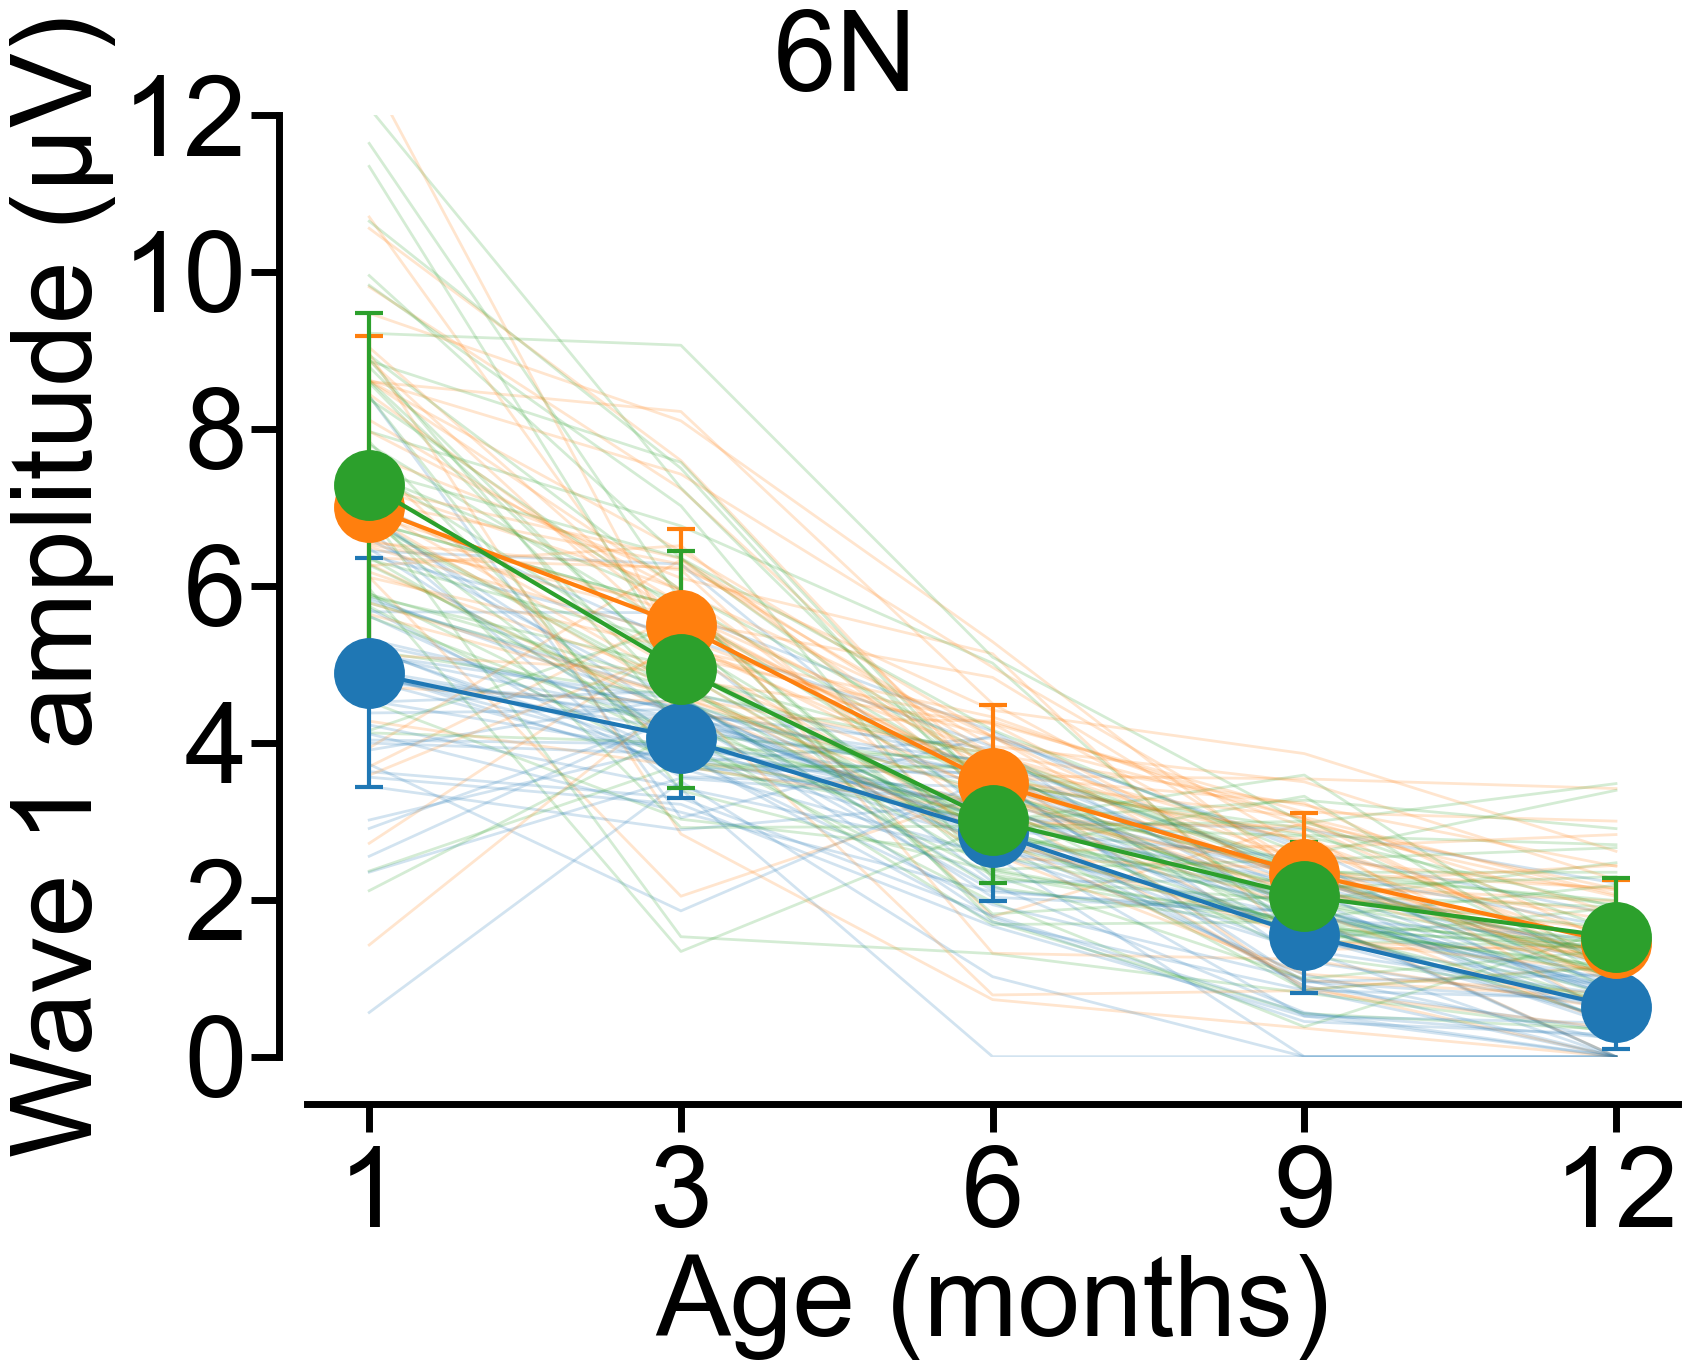

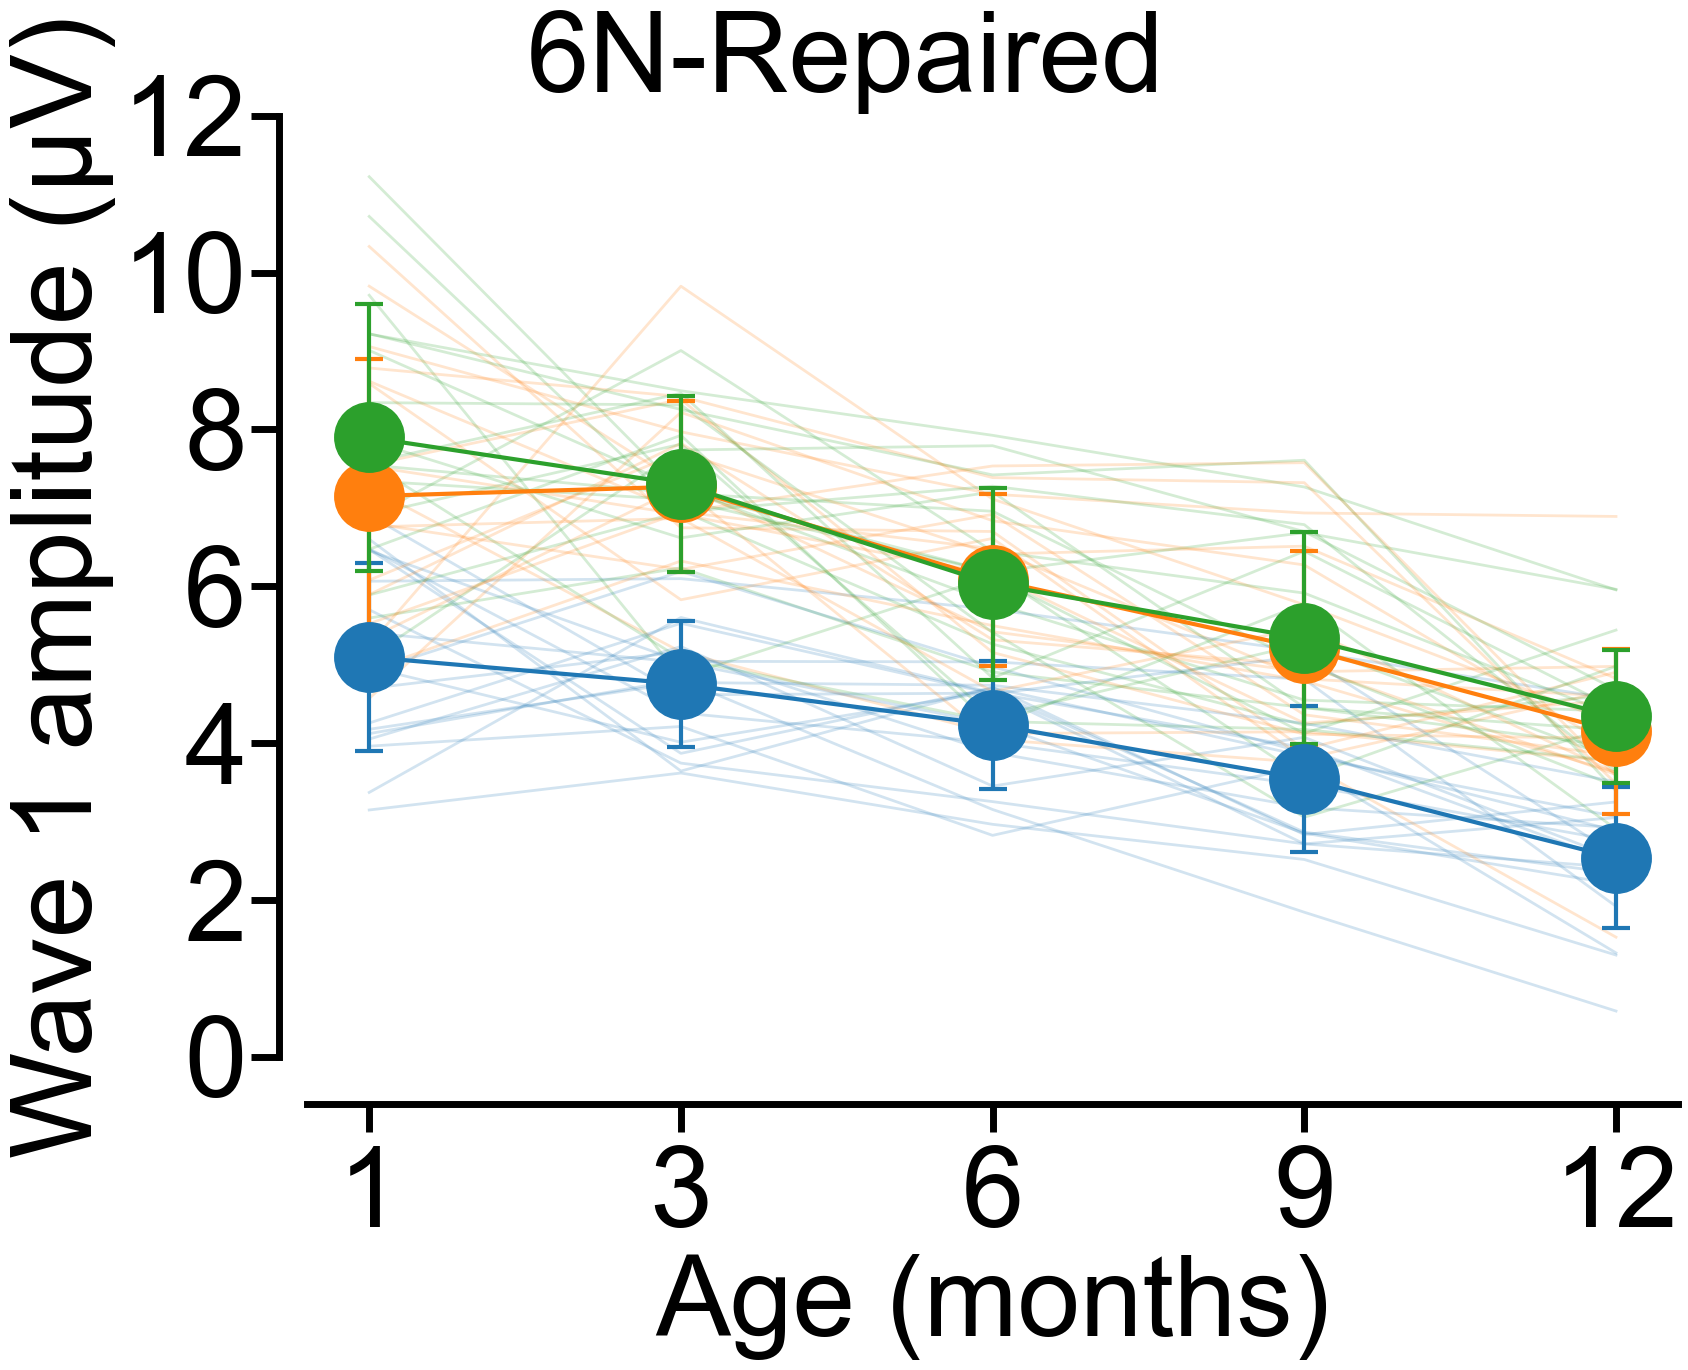

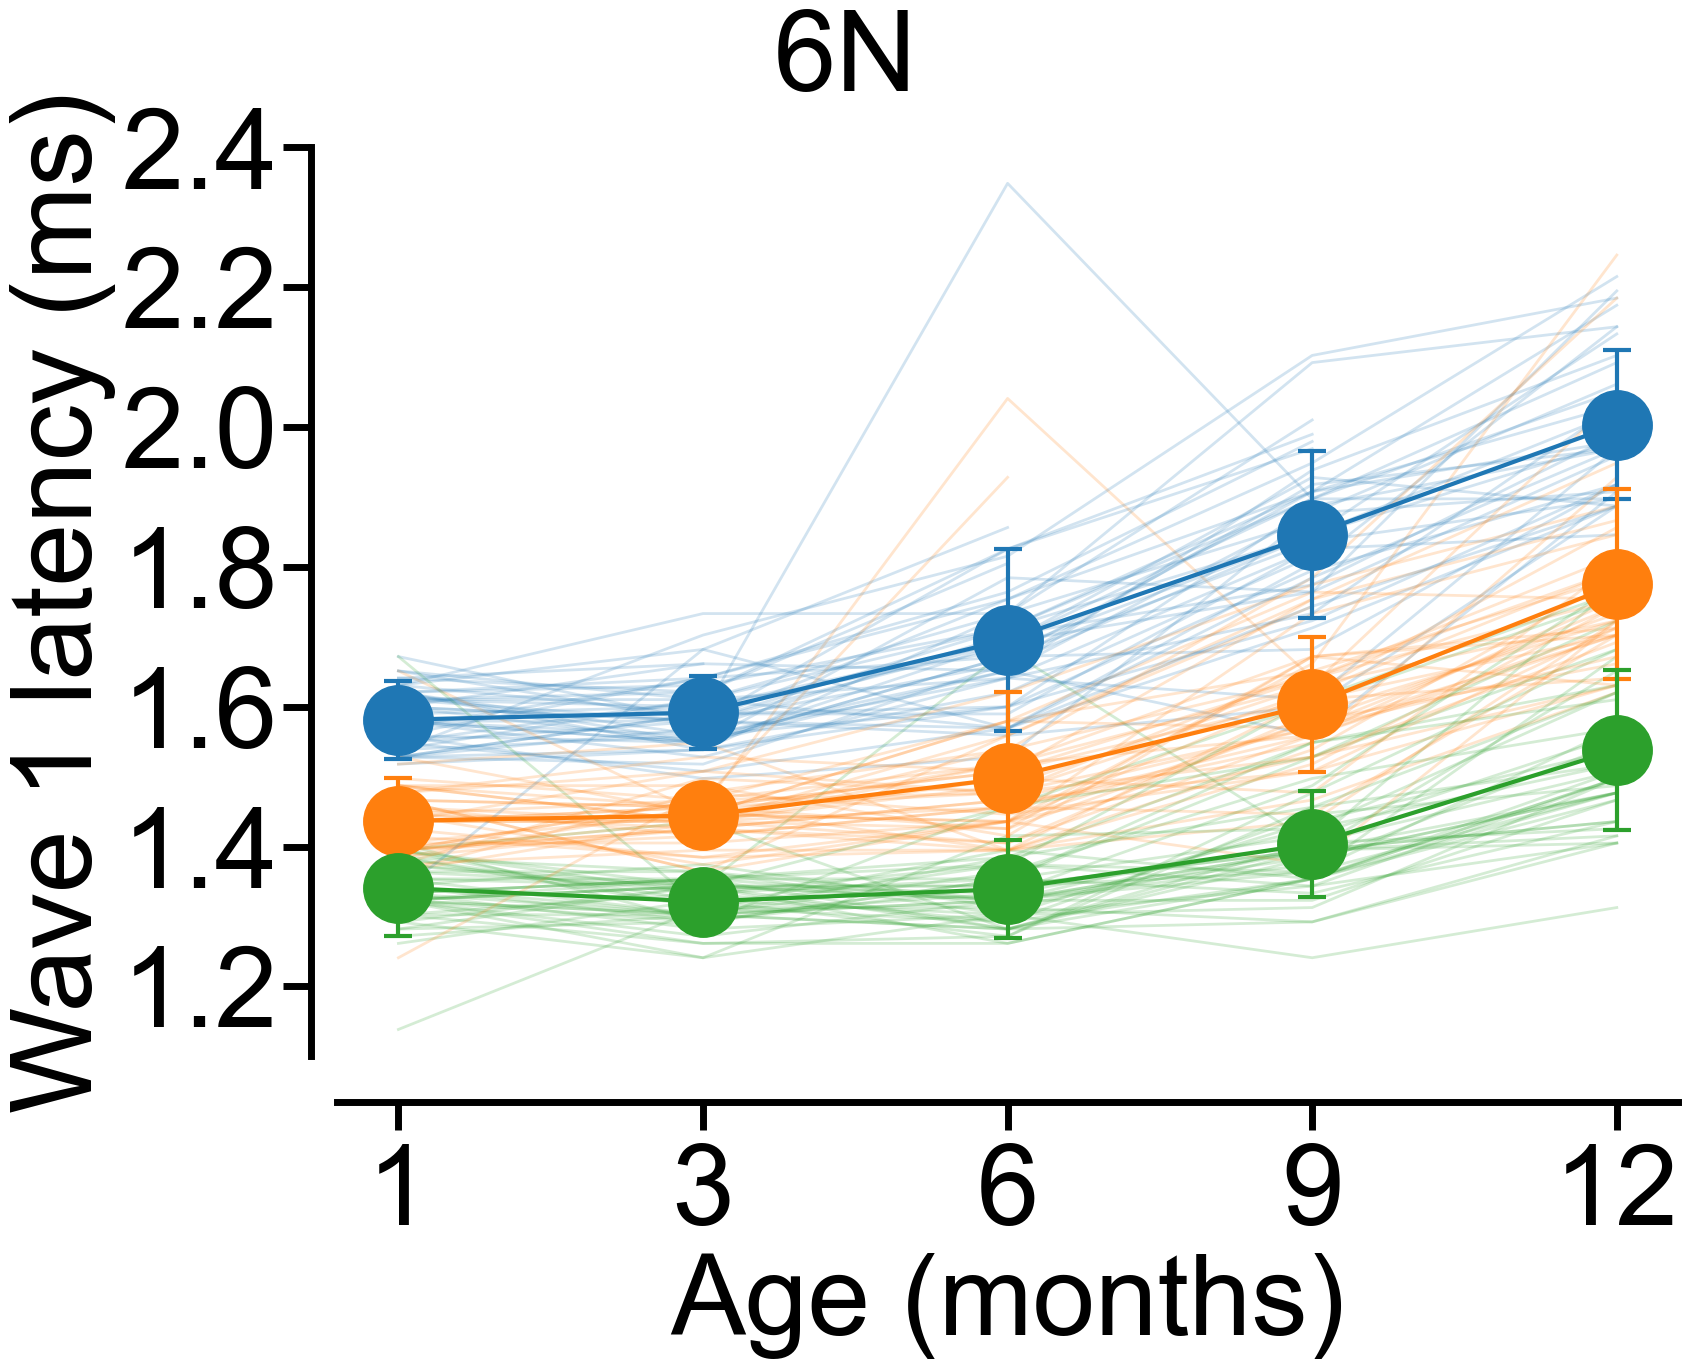

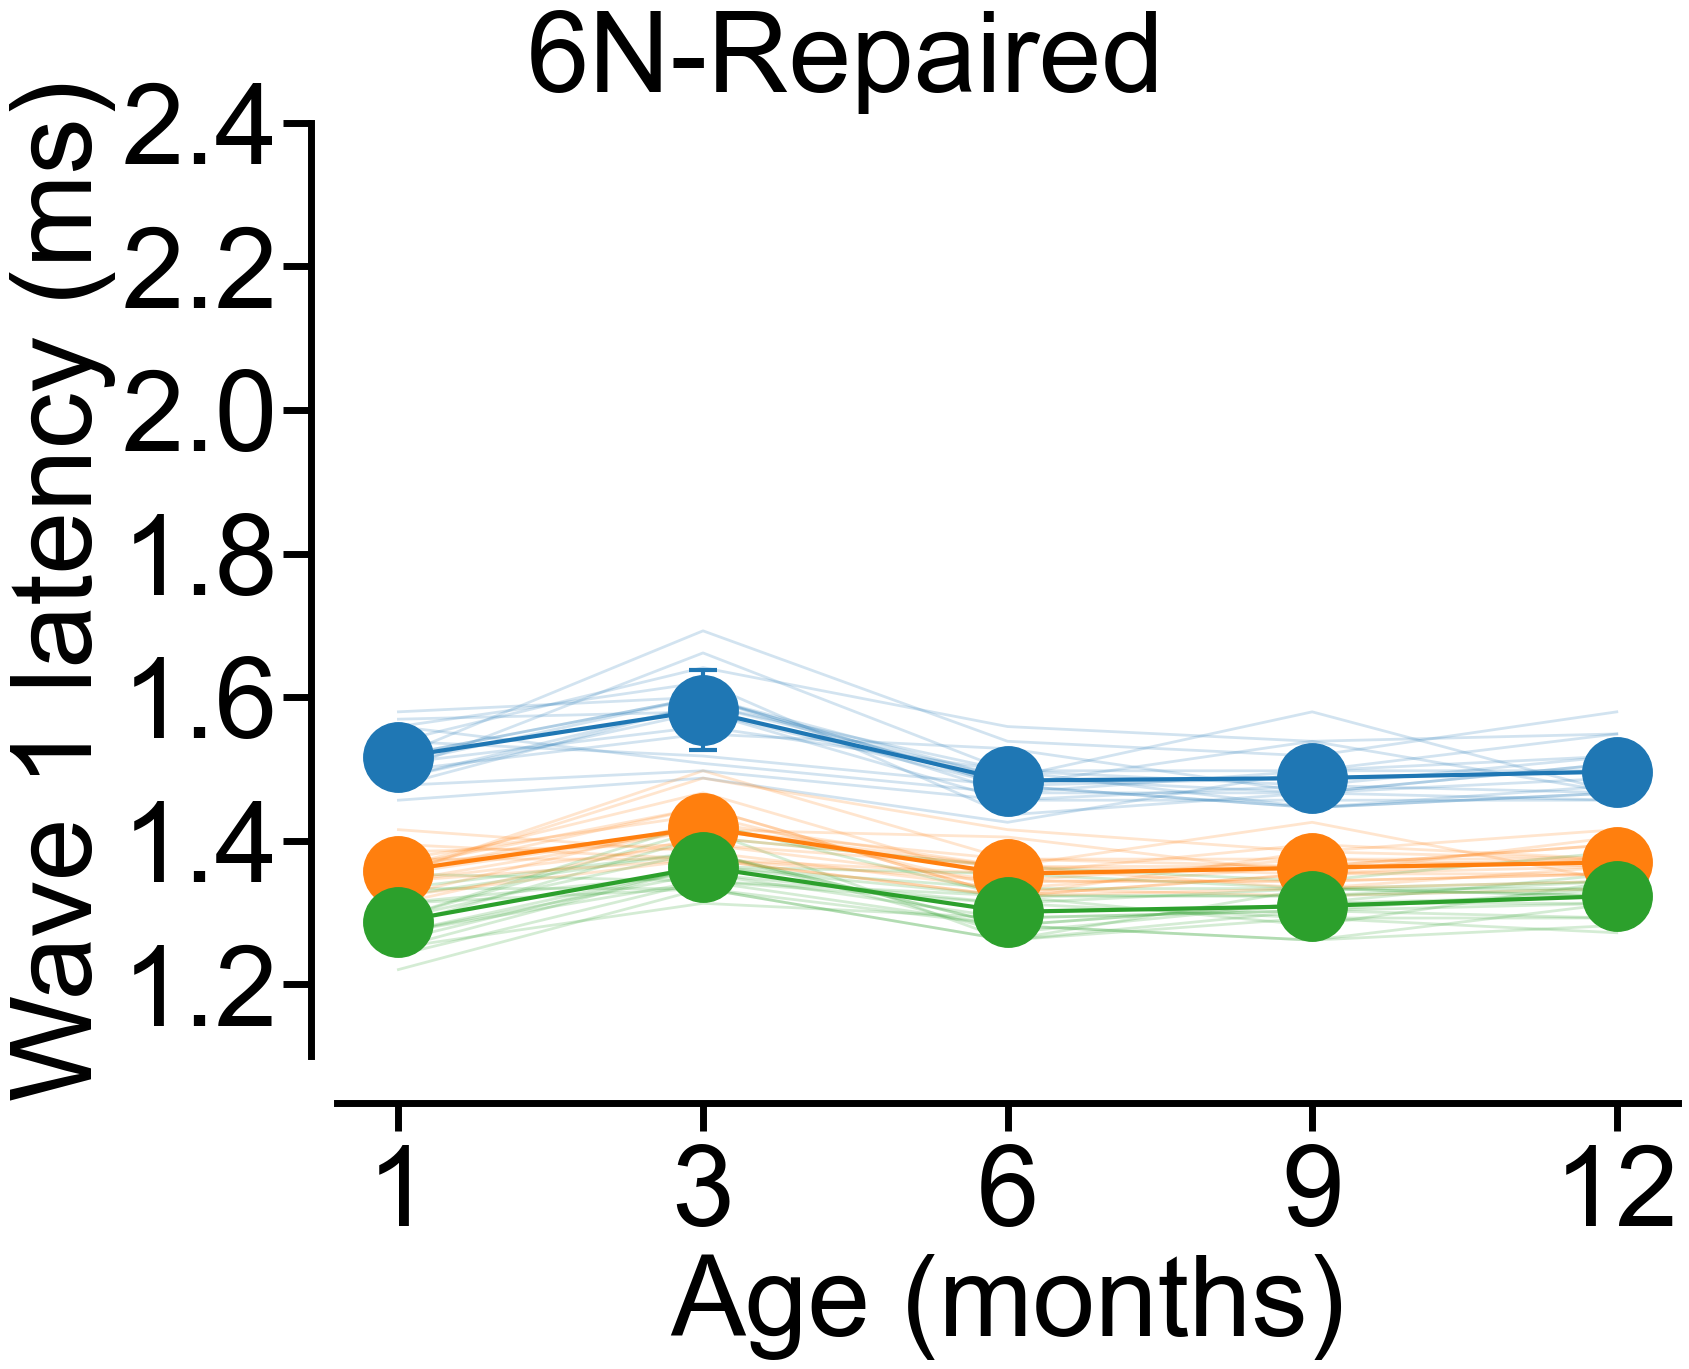

In [11]:
colorcycle = dict(zip(df['Intensity'].unique(),plt.rcParams['axes.prop_cycle'].by_key()['color'][0:]))

strain = '6N'
variable = 'Wave1 amp'
ylabel = 'Wave 1 amplitude (μV)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(0,12)
f.savefig('./Panels/waveampVsAge6N.pdf',dpi=1200,transparent=True)


strain = 'Repaired'
variable = 'Wave1 amp'
ylabel = 'Wave 1 amplitude (μV)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(0,12)
f.savefig('./Panels/waveampVsAgeRep.pdf',dpi=1200,transparent=True)

strain = '6N'
variable = 'Wave1 latency'
ylabel = 'Wave 1 latency (ms)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(1.1,2.4)
f.savefig('./Panels/wavelatVsAge6N.pdf',dpi=1200,transparent=True)

strain = 'Repaired'
variable = 'Wave1 latency'
ylabel = 'Wave 1 latency (ms)'
f,ax = makeFigure(df,strain,variable,ylabel,colorcycle=colorcycle)
ax.set_ylim(1.1,2.4)
f.savefig('./Panels/wavelatVsAgeRep.pdf',dpi=1200,transparent=True)
                  

### CV model results

Amplitude MAE

In [29]:
savefolder = os.path.join('../../','results','2024-04-26-regressionResults')

modelNames = ['RandomForestRegressor']
intensities = ['55dB','75dB','95dB']
targetAge = ['6mont']
inputFreqs = ['[100]']# 'None'
targetAges = ['6month','9month','12month']
inputAges =  ['[\'1month\']','[\'1month\', \'3month\']','[\'1month\', \'3month\', \'6month\']','[\'1month\', \'3month\', \'6month\', \'9month\']']
modelType = 'waveamp'
dfs = []
dfsTest = []

for modelName in modelNames:
    for inputFreq in inputFreqs:
        for targetAge in targetAges:
            for inputAge in inputAges:
                for intensity in intensities:
                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsCV.csv'
                    ddf = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    ddf['InputFreq'] = inputFreq
                    ddf['TargetAge'] = targetAge
                    ddf['InputAge'] = inputAge
                    ddf['ModelName'] = modelName
                    ddf['SoundLevel'] = intensity
                    dfs.append(ddf)

                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsTest.csv'
                    df2 = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    df2['InputFreq'] = inputFreq
                    df2['TargetAge'] = targetAge
                    df2['InputAge'] = inputAge
                    df2['ModelName'] = modelName
                    df2['SoundLevel'] = intensity
                    dfsTest.append(df2)
                
masterWaveAmp = pd.concat(dfs,ignore_index=True)
masterAmpTest = pd.concat(dfsTest,ignore_index=True)
masterAmpTest['Mouse ID'] = masterAmpTest['Mouse ID'].astype(str)


masterWaveAmp['Age'] = masterWaveAmp['TargetAge']
#master['Age (months)'] = master['TargetAge'].str.split('month').apply(lambda x:int(x[0])) # Do this to comply with the threshold
avgdf = pd.DataFrame(df.groupby(['Age','Intensity'])['Wave1 amp'].mean())


masterWaveAmp['MAEpercent'] = None
for i,el in masterWaveAmp.iterrows():
    masterWaveAmp.loc[i,'MAEpercent'] = el['MAE']/avgdf.loc[(el['Age'],int(el['SoundLevel'][:2]))].values[0]
masterWaveAmp['Strain'] = 'Wave 1 amplitude'#do this for compatibility
masterWaveAmp=masterWaveAmp.rename({'SoundLevel':'Intensity'},axis=1)
masterWaveAmp['Intensity'] = masterWaveAmp['Intensity'].apply(lambda x:int(x[:2]))

   Age  Intensity      mean       std
3    0         55  0.728589  0.228726
   Age  Intensity      mean       std
6    1         55  0.748735  0.265759
   Age  Intensity      mean       std
0    2         55  0.627877  0.240277
   Age  Intensity      mean       std
4    0         75  0.794531  0.318998
   Age  Intensity      mean       std
7    1         75  0.945668  0.371128
   Age  Intensity     mean       std
1    2         75  0.88797  0.330205
   Age  Intensity      mean       std
5    0         95  1.031737  0.311208
   Age  Intensity      mean       std
8    1         95  0.958936  0.405564
   Age  Intensity      mean       std
2    2         95  0.805501  0.299532
   Age  Intensity      mean       std
3    0         55  0.223665  0.070215
   Age  Intensity      mean       std
6    1         55  0.350331  0.124348
   Age  Intensity      mean       std
0    2         55  0.529886  0.202777
   Age  Intensity      mean       std
4    0         75  0.187469  0.075267
   Age  Intens

(0.0, 1.08365576516904)

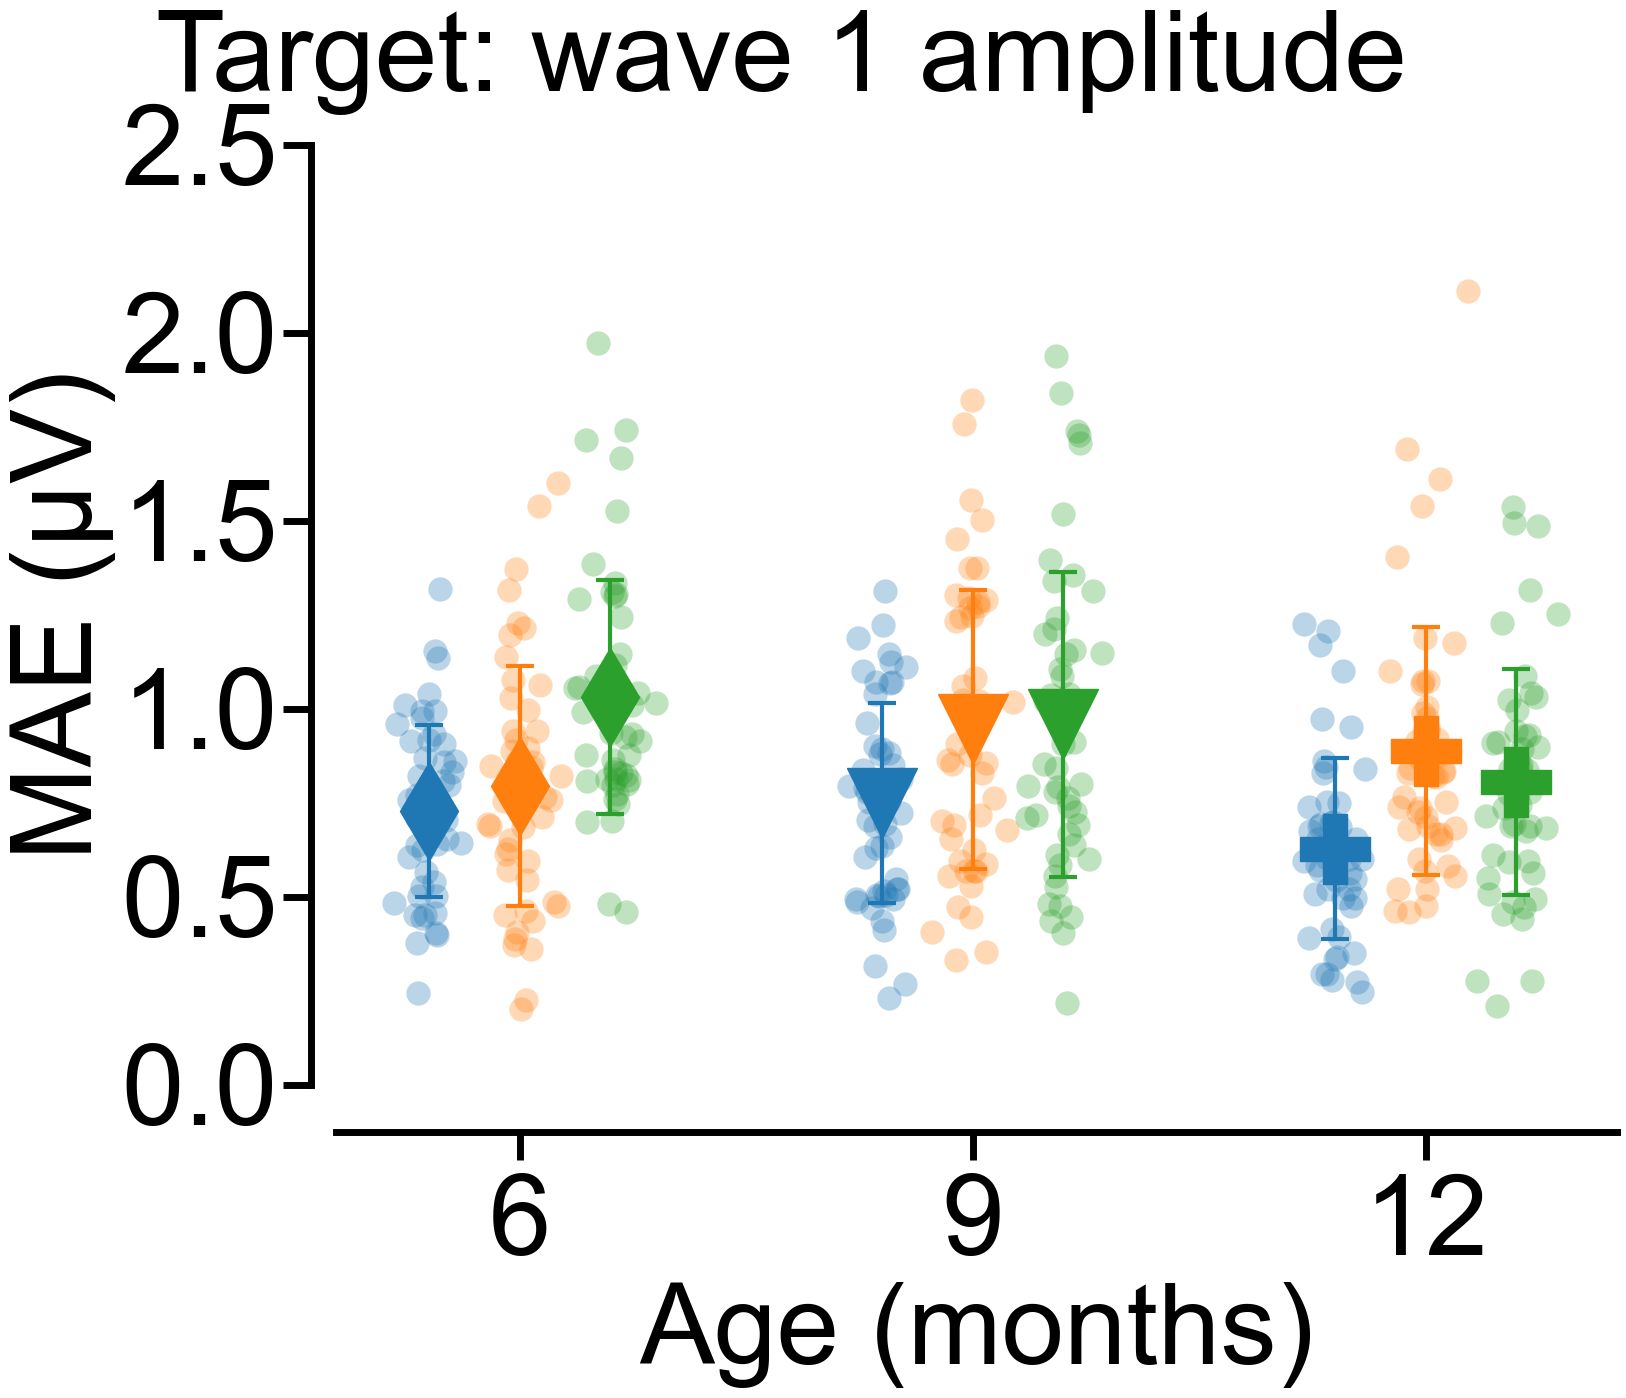

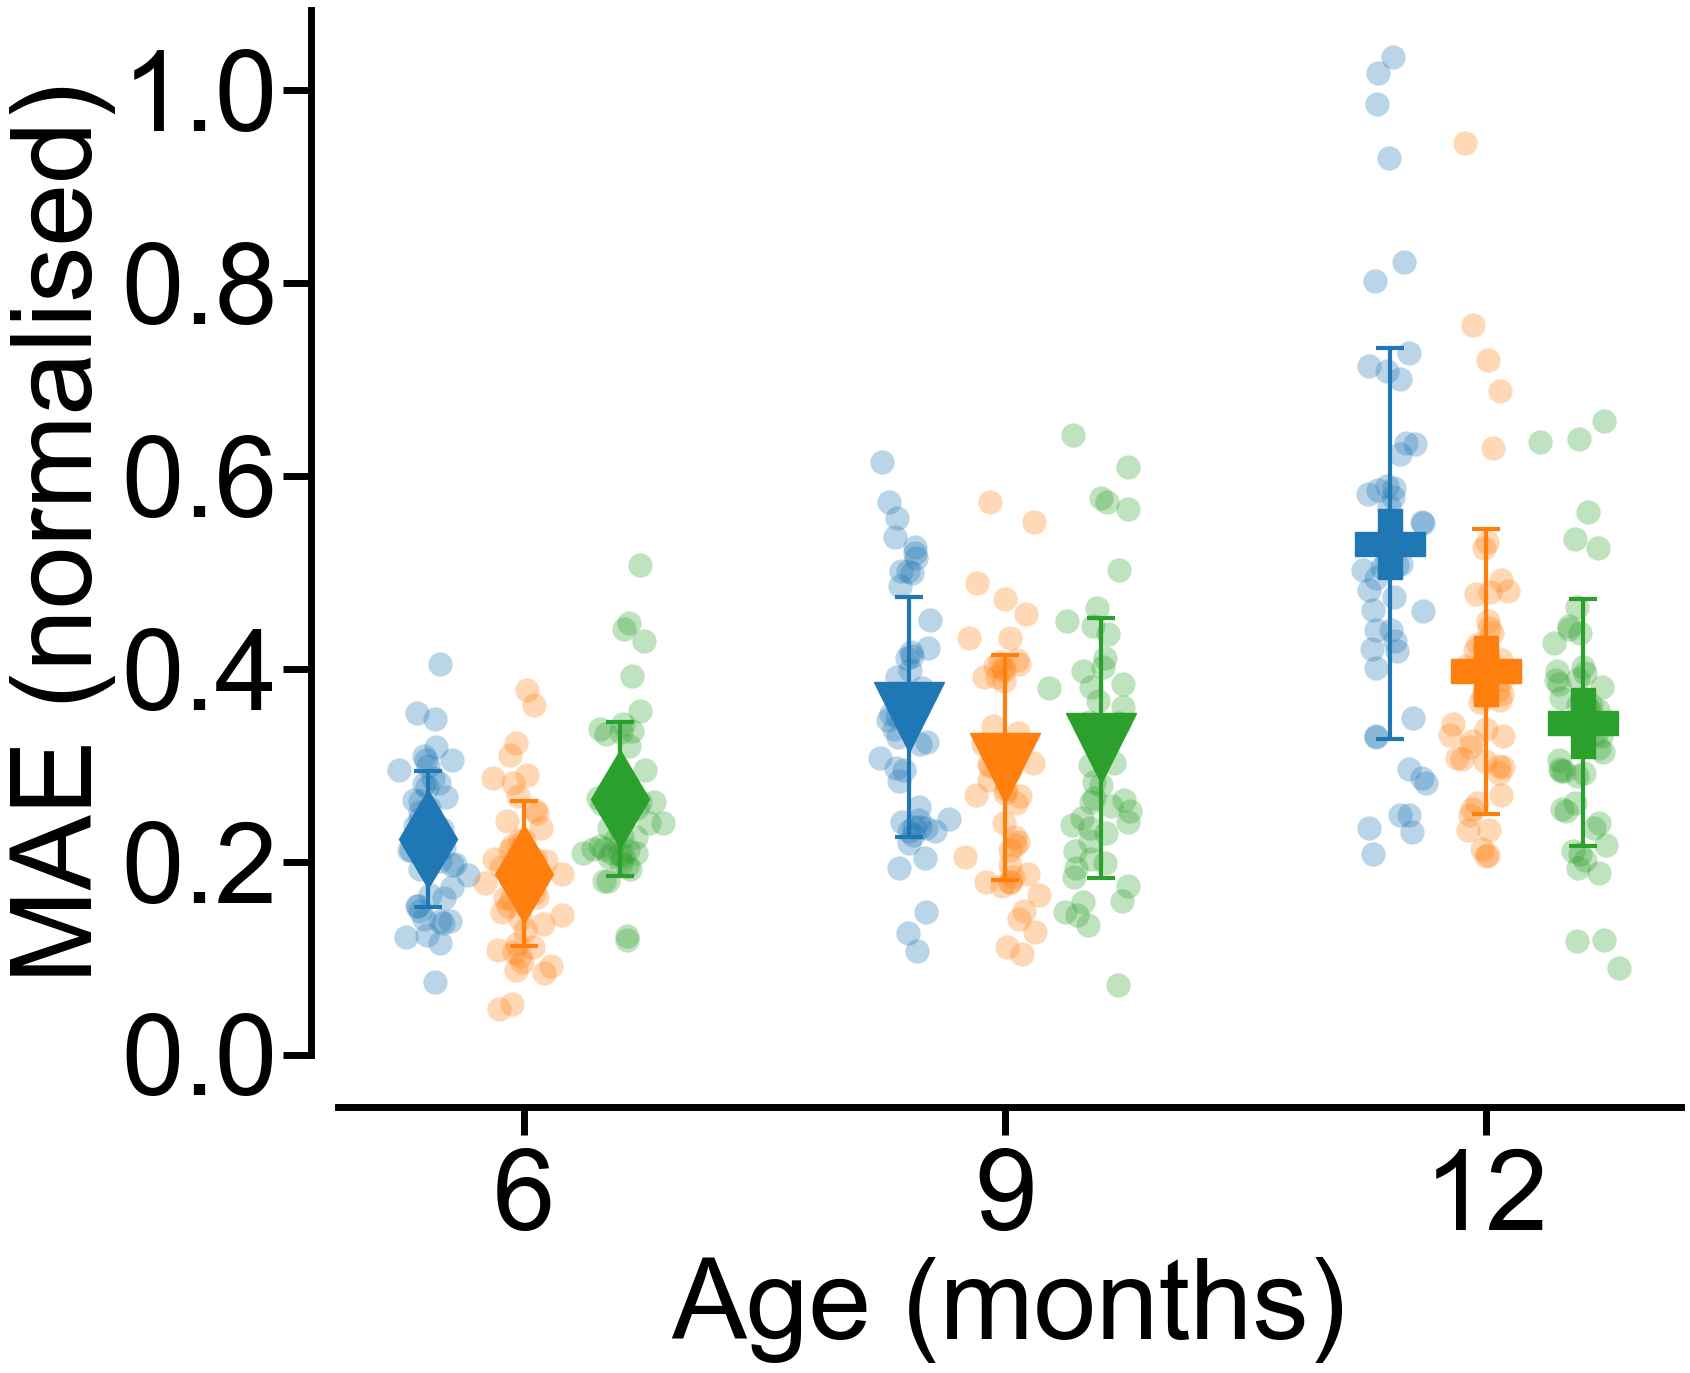

In [30]:
f,ax =makeFigureMAE(masterWaveAmp,strain='Wave 1 amplitude',variable='MAE',ylabel='MAE (μV)',colorcycle=colorcycle,title='Target: wave 1 amplitude')
ylim(0,2.5)

f.savefig('./Panels/waveampVsAgeMAE.pdf',dpi=1200,transparent=True)

makeFigureMAE(masterWaveAmp,strain='Wave 1 amplitude',variable='MAEpercent',ylabel='MAE (normalised)',colorcycle=colorcycle)
ylim(0,)

Latency MAE

In [31]:
savefolder = os.path.join('../../','results','2024-04-26-regressionResults')

modelNames = ['RandomForestRegressor']
intensities = ['55dB','75dB','95dB']
targetAge = ['6mont']
inputFreqs = ['[100]']# 'None'
targetAges = ['6month','9month','12month']
inputAges =  ['[\'1month\']','[\'1month\', \'3month\']','[\'1month\', \'3month\', \'6month\']','[\'1month\', \'3month\', \'6month\', \'9month\']']
modelType = 'wavelatency'
dfs = []
dfsTest = []

for modelName in modelNames:
    for inputFreq in inputFreqs:
        for targetAge in targetAges:
            for inputAge in inputAges:
                for intensity in intensities:
                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsCV.csv'
                    ddf = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    ddf['InputFreq'] = inputFreq
                    ddf['TargetAge'] = targetAge
                    ddf['InputAge'] = inputAge
                    ddf['ModelName'] = modelName
                    ddf['SoundLevel'] = intensity
                    dfs.append(ddf)

                    filename = f'{modelName}{intensity}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsTest.csv'
                    df2 = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                    df2['InputFreq'] = inputFreq
                    df2['TargetAge'] = targetAge
                    df2['InputAge'] = inputAge
                    df2['ModelName'] = modelName
                    df2['SoundLevel'] = intensity
                    dfsTest.append(df2)
                
masterWaveLat = pd.concat(dfs,ignore_index=True)

masterLatTest = pd.concat(dfsTest,ignore_index=True)
masterLatTest['Mouse ID'] = masterLatTest['Mouse ID'].astype(str)


masterWaveLat['Age'] = masterWaveLat['TargetAge']
#master['Age (months)'] = master['TargetAge'].str.split('month').apply(lambda x:int(x[0])) # Do this to comply with the threshold
avgdf = pd.DataFrame(df.groupby(['Age','Intensity'])['Wave1 latency'].mean())


masterWaveLat['MAEpercent'] = None
for i,el in masterWaveLat.iterrows():
    masterWaveLat.loc[i,'MAEpercent'] = el['MAE']/avgdf.loc[(el['Age'],int(el['SoundLevel'][:2]))].values[0]
masterWaveLat['Strain'] = 'Wave 1 latency'#do this for compatibility
masterWaveLat=masterWaveLat.rename({'SoundLevel':'Intensity'},axis=1)
masterWaveLat['Intensity'] = masterWaveLat['Intensity'].apply(lambda x:int(x[:2]))

   Age  Intensity      mean       std
3    0         55  0.089413  0.049266
   Age  Intensity      mean       std
6    1         55  0.104047  0.031699
   Age  Intensity      mean       std
0    2         55  0.130061  0.050174
   Age  Intensity      mean       std
4    0         75  0.070063  0.038012
   Age  Intensity      mean       std
7    1         75  0.082353  0.027523
   Age  Intensity      mean       std
1    2         75  0.101282  0.042588
   Age  Intensity      mean       std
5    0         95  0.047023  0.022252
   Age  Intensity      mean       std
8    1         95  0.054046  0.020654
   Age  Intensity      mean       std
2    2         95  0.089535  0.030042
   Age  Intensity      mean       std
3    0         55  0.054744  0.030163
   Age  Intensity      mean       std
6    1         55  0.059913  0.018253
   Age  Intensity      mean       std
0    2         55  0.071149  0.027448
   Age  Intensity      mean       std
4    0         75  0.048117  0.026106
   Age  Inte

(0.0, 0.167393420581888)

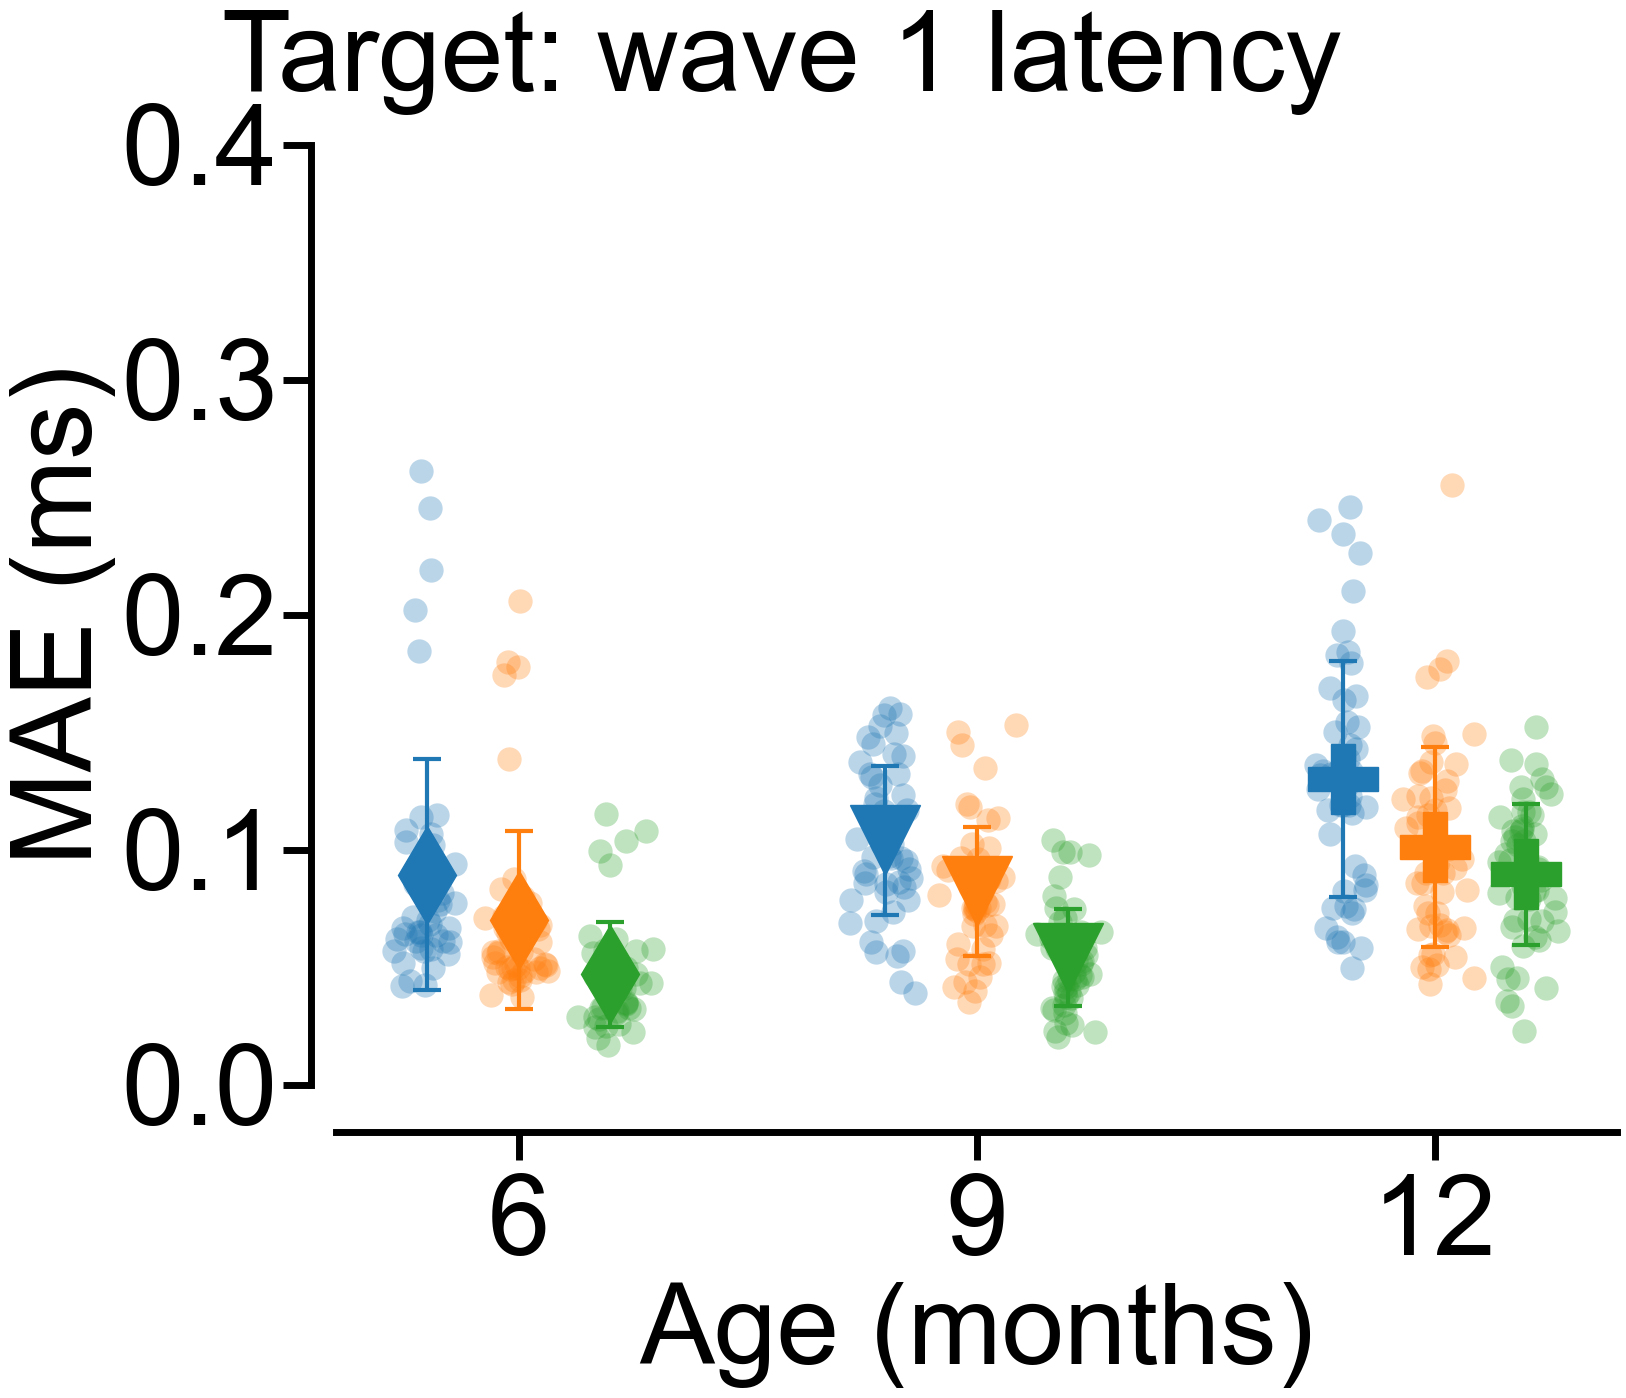

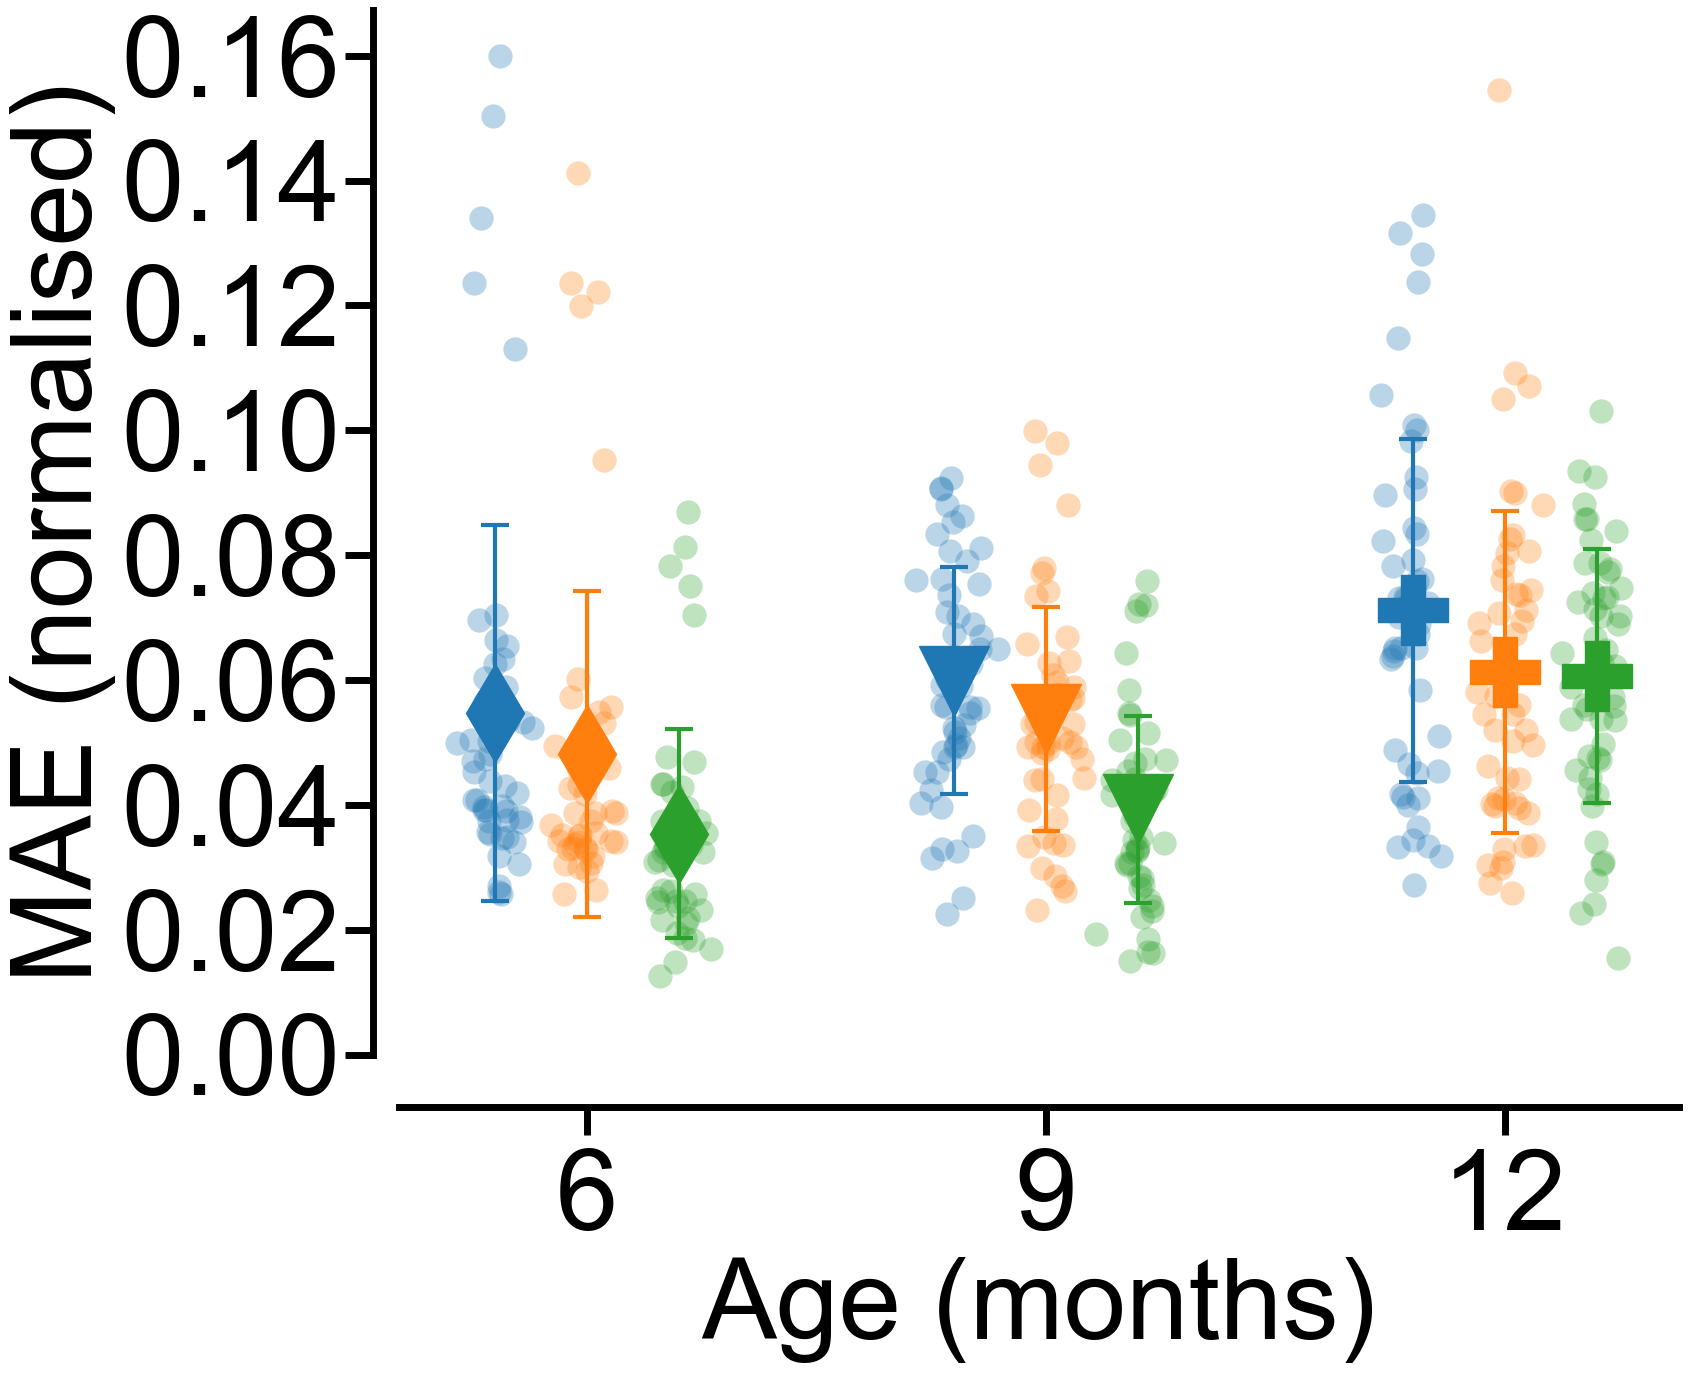

In [32]:
f,ax =makeFigureMAE(masterWaveLat,strain='Wave 1 latency',variable='MAE',ylabel='MAE (ms)',colorcycle=colorcycle,title='Target: wave 1 latency')
ylim(0,0.4)

ax.set_yticks(arange(0,0.41,0.1))
f.savefig('./Panels/wavelatVsAgeMAE.pdf',dpi=1200,transparent=True)
makeFigureMAE(masterWaveLat,strain='Wave 1 latency',variable='MAEpercent',ylabel='MAE (normalised)',colorcycle=colorcycle)
ylim(0,)

## 2 - Threshold parameters over time

In [34]:
# Thresholds figure
frequencies = ['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz',
       '30 kHz', '36 kHz', '42 kHz']

fs = 195000.0/2.0 # Acquisition sampling rate

data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
thresholds['ID'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[0].astype(int)
thresholds['Age (months)'] = thresholds['MouseN - AGE'].str.split(' - ',expand=True)[1].str.split('month',expand=True)[0].astype(int)
strain = []
for el in thresholds['ID']:
    strain.append(data.loc[data['ID']==el,'Strain'].values[0])
thresholds['Strain'] = strain
thresholds['Age'] = thresholds['Age (months)'].apply(lambda x: str(x)+'month')
thresholds['Intensity'] = 85

mouseList = thresholds.query("Age == '12month'")['ID'].unique() #chose only mice which have been investigated thorughout
thresholds = thresholds.query("ID in @mouseList")


The dataset version is: 20230914 - V41


### Statistical test on thresholds over time (1 way anova)

In [36]:
thresholds['Mean threshold'] = thresholds[['Click', '3 kHz', '6 kHz', '12 kHz', '18 kHz', '24 kHz',
       '30 kHz', '36 kHz', '42 kHz']].mean(1)


In [37]:
meantr1month = thresholds.query("Age=='1month'")[['ID','Mean threshold']]
meantr1month['Age'] = '1month'
meantr1month2 = meantr1month.copy()
meantr1month2['Age'] = '3month'
meantr1month3 = meantr1month.copy()
meantr1month3['Age'] = '6month'
meantr1month4 = meantr1month.copy()
meantr1month4['Age'] = '9month'
meantr1month5 = meantr1month.copy()
meantr1month5['Age'] = '12month'
meantr1month = pd.concat([meantr1month,meantr1month2,meantr1month3,meantr1month4,meantr1month5]).set_index(['ID','Age'])

thresholds = thresholds.set_index(['ID','Age'])
thresholds['Shift in mean threshold'] = (thresholds['Mean threshold']-meantr1month['Mean threshold'])
thresholds=thresholds.reset_index()
df2 = thresholds.copy()
df2 = df2.rename({'Shift in mean threshold':'smt'},axis=1)
df2['Age'] = df2['Age'].astype('category')
#df2 = df2.query("Strain=='Repaired'")

In [38]:
%%R -i df2 -o out2,out0,out1,out3,ss
res.aov <- aov(smt ~ Age+Strain, df2) # 'accuracy', 'test_precision_scorer_avg',     'test_recall_scorer_avg', 'roc_auc_score'
ss <- summary(res.aov)

out2 <- as.data.frame(TukeyHSD(res.aov)[2])
out0 <- as.data.frame(TukeyHSD(res.aov)[0])
out1 <- as.data.frame(TukeyHSD(res.aov)[1])
out3 <- as.data.frame(TukeyHSD(res.aov)[3])

In [39]:
ss

o{'None':                 Df        Sum Sq       Mean Sq     F value        Pr(>F)
Age            4.0  32080.045072   8020.011268  144.201728  2.195911e-69
Strain         1.0  19435.533608  19435.533608  349.455561  1.069537e-52
Residuals    309.0  17185.532432     55.616610         NaN           NaN, }

In [40]:
out1

Age.diff    Age.lwr    Age.upr     Age.p.adj
1month-12month -28.350970 -31.997030 -24.704910  1.023404e-12
3month-12month -20.652557 -24.298617 -17.006497  1.023404e-12
6month-12month -12.760141 -16.406201  -9.114081  1.070921e-12
9month-12month  -6.102293  -9.748353  -2.456233  6.236961e-05
3month-1month    7.698413   4.052353  11.344473  1.689994e-07
6month-1month   15.590829  11.944769  19.236889  1.028067e-12
9month-1month   22.248677  18.602617  25.894737  1.023404e-12
6month-3month    7.892416   4.246356  11.538476  7.661963e-08
9month-3month   14.550265  10.904205  18.196325  1.054490e-12
9month-6month    6.657848   3.011788  10.303908  9.035677e-06

### Threshold figures

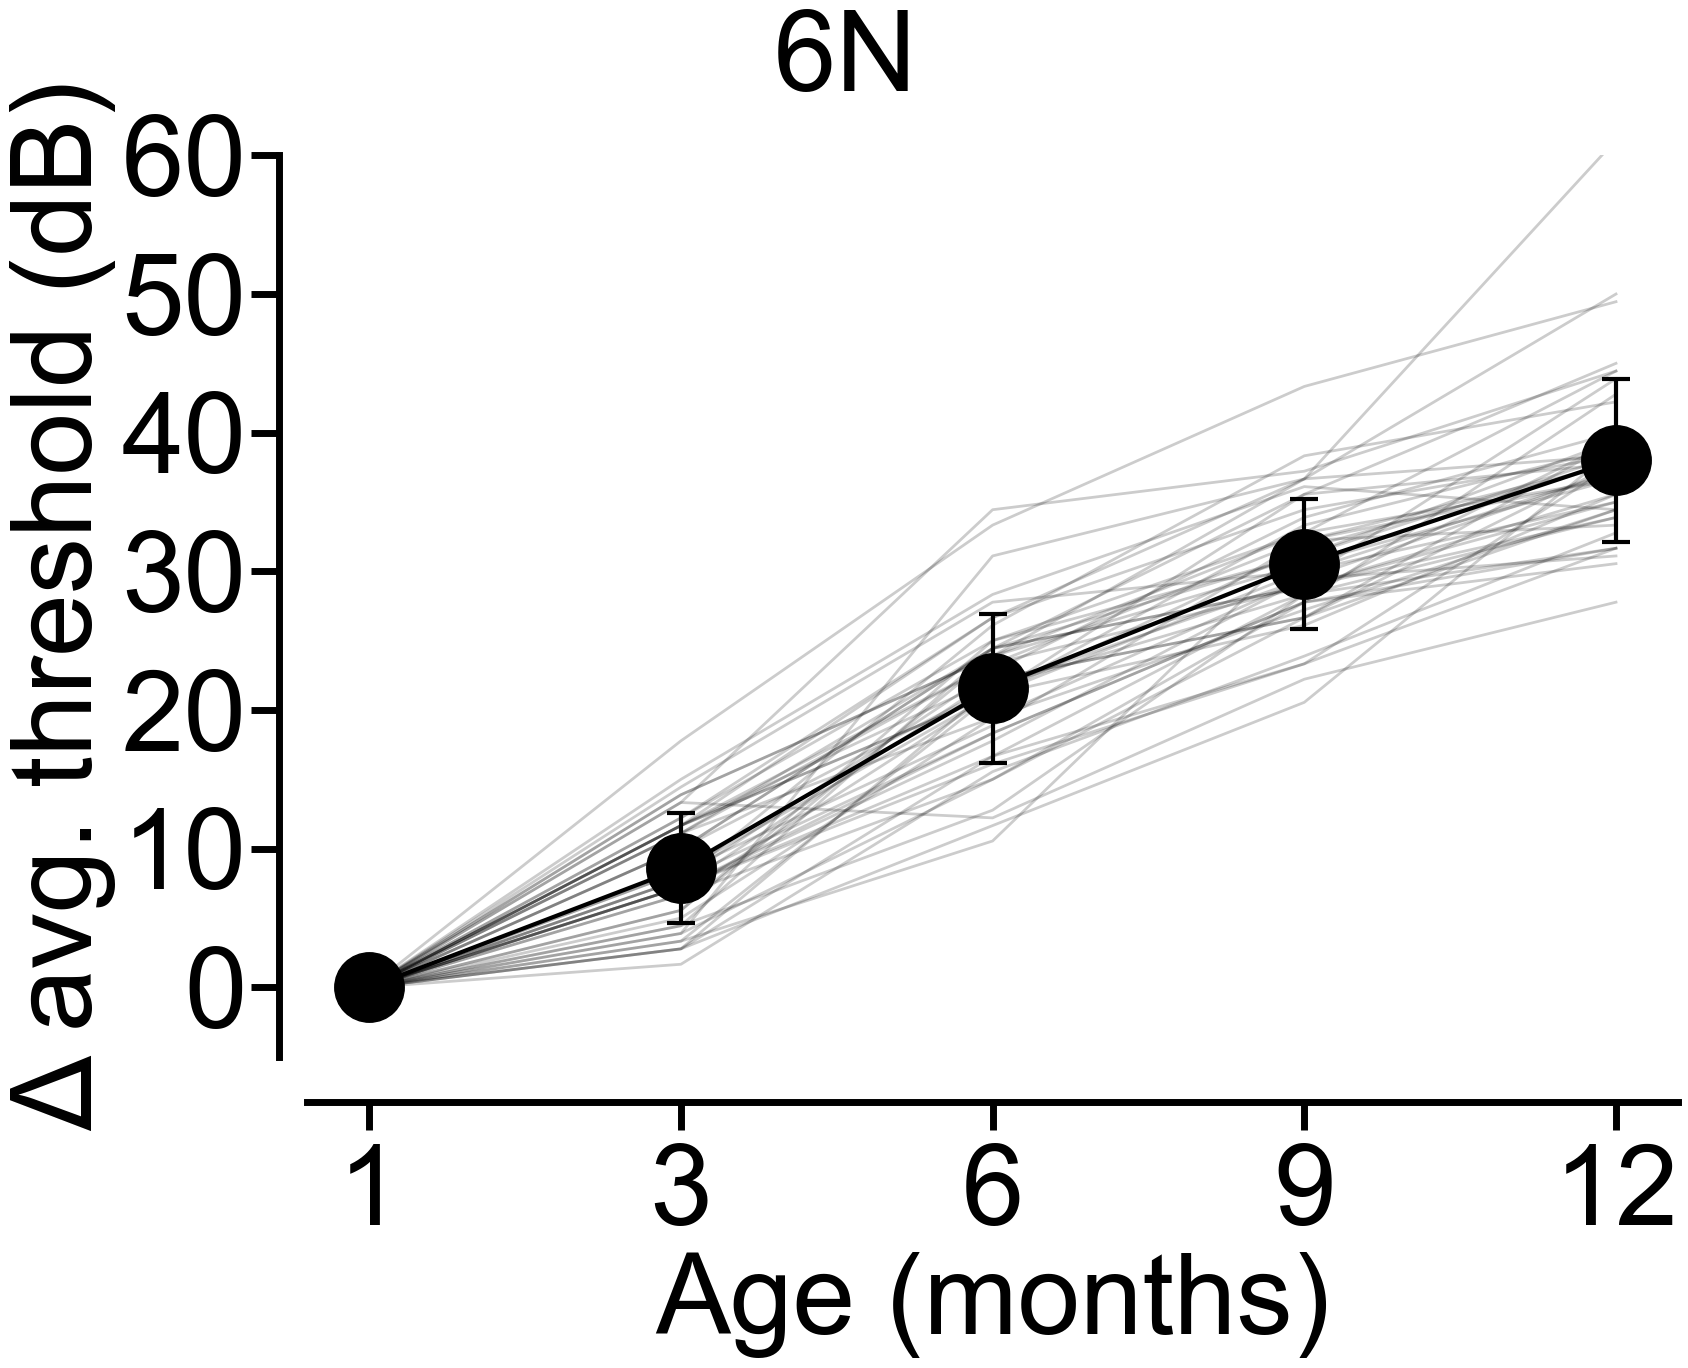

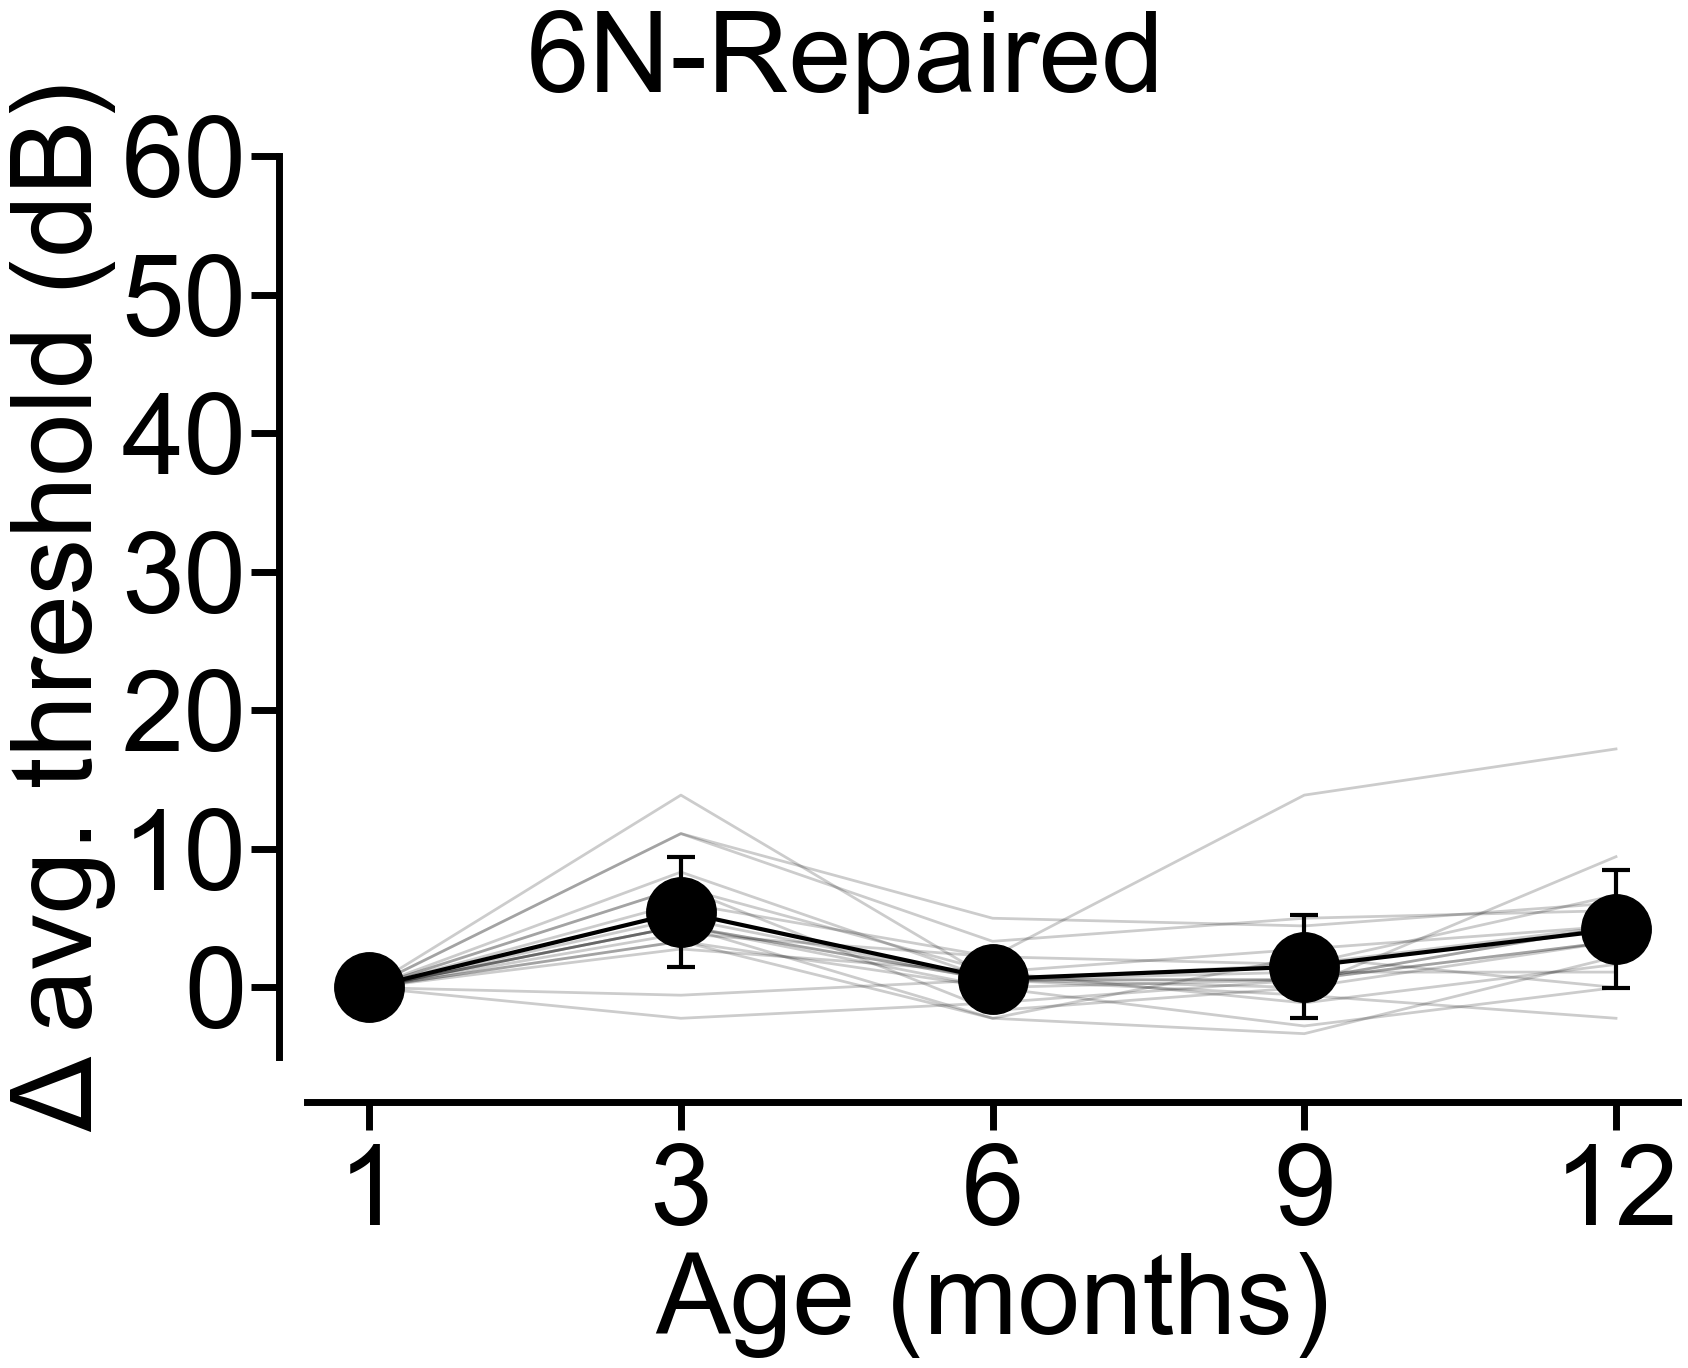

In [42]:
f,ax = makeFigure(thresholds,'6N','Shift in mean threshold','Δ avg. threshold (dB)',colorcycle={85:'k'},ylim=(-5,60),avgFunc='mean',stdFunc='std')
#ax.set_yticks(arange(20,120,20))#
f.savefig('./Panels/waveAvgThreshShiftVsAge6N.pdf',dpi=1200,transparent=True)

f,ax = makeFigure(thresholds,'Repaired','Shift in mean threshold','Δ avg. threshold (dB)',colorcycle={85:'k'},ylim=(-5,60),avgFunc='mean',stdFunc='std')
#ax.set_yticks(arange(20,120,20))
f.savefig('./Panels/waveAvgThreshShiftVsAgeRep.pdf',dpi=1200,transparent=True)

### CV model results - threshold

In [43]:
savefolder = os.path.join('../../','results','2024-04-26-regressionResults')
modelNames = ['RandomForestRegressor']
inputFreqs = ['[100]']#,'None'
targetAges = ['6month','9month','12month']
inputAges =  ['[\'1month\']','[\'1month\', \'3month\']','[\'1month\', \'3month\', \'6month\']','[\'1month\', \'3month\', \'6month\', \'9month\']']
modelType = 'DThreshold'
dfs = []
dfsTest = []

for modelName in modelNames:
    for inputFreq in inputFreqs:
        for targetAge in targetAges:
            for inputAge in inputAges:
                filename = f'{modelName}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsCV.csv'
                df = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                df['InputFreq'] = inputFreq
                df['TargetAge'] = targetAge
                df['InputAge'] = inputAge
                df['ModelName'] = modelName
                dfs.append(df)

                filename = f'{modelName}{targetAge}-{modelType}-{inputAge}-inputFreq{inputFreq}-resultsTest.csv'
                df2 = pd.read_csv(os.path.join(savefolder,filename),index_col=0)
                df2['InputFreq'] = inputFreq
                df2['TargetAge'] = targetAge
                df2['InputAge'] = inputAge
                df2['ModelName'] = modelName
                dfsTest.append(df2)
master = pd.concat(dfs,ignore_index=True)
master['Age'] = master['TargetAge']
#master['Age (months)'] = master['TargetAge'].str.split('month').apply(lambda x:int(x[0])) # Do this to comply with the threshold
masterTest = pd.concat(dfsTest,ignore_index=True)
masterTestMelt = masterTest.melt(value_vars = ['y_predict','y_test'],id_vars = ['Mouse ID', 'Strain', 'InputFreq', 'TargetAge','InputAge', 'ModelName'])


masterTest['Mouse ID'] = masterTest['Mouse ID'].astype(str)
masterTestMelt['Mouse ID'] = masterTestMelt['Mouse ID'].astype(str)



#Calculate the noramlised MAE (to the average threshold shift at that age)
avgThresholds = pd.DataFrame(thresholds.query("Strain=='6N'").groupby('Age')['Shift in mean threshold'].mean())

master['MAEpercent'] = None
for i,el in master.iterrows():
    master.loc[i,'MAEpercent'] = el['MAE']/avgThresholds.loc[el['Age']].values[0]
master['Strain'] = 'Δ avg. threshold'
master['Intensity']= 85

   Age  Intensity      mean       std
1    0         85  5.256171  1.359822
   Age  Intensity      mean       std
2    1         85  5.662842  1.997521
   Age  Intensity      mean       std
0    2         85  6.975742  2.502866
   Age  Intensity      mean       std
1    0         85  0.243564  0.063012
   Age  Intensity      mean     std
2    1         85  0.185404  0.0654
   Age  Intensity      mean       std
0    2         85  0.183513  0.065843


(0.0, 0.40692196394769425)

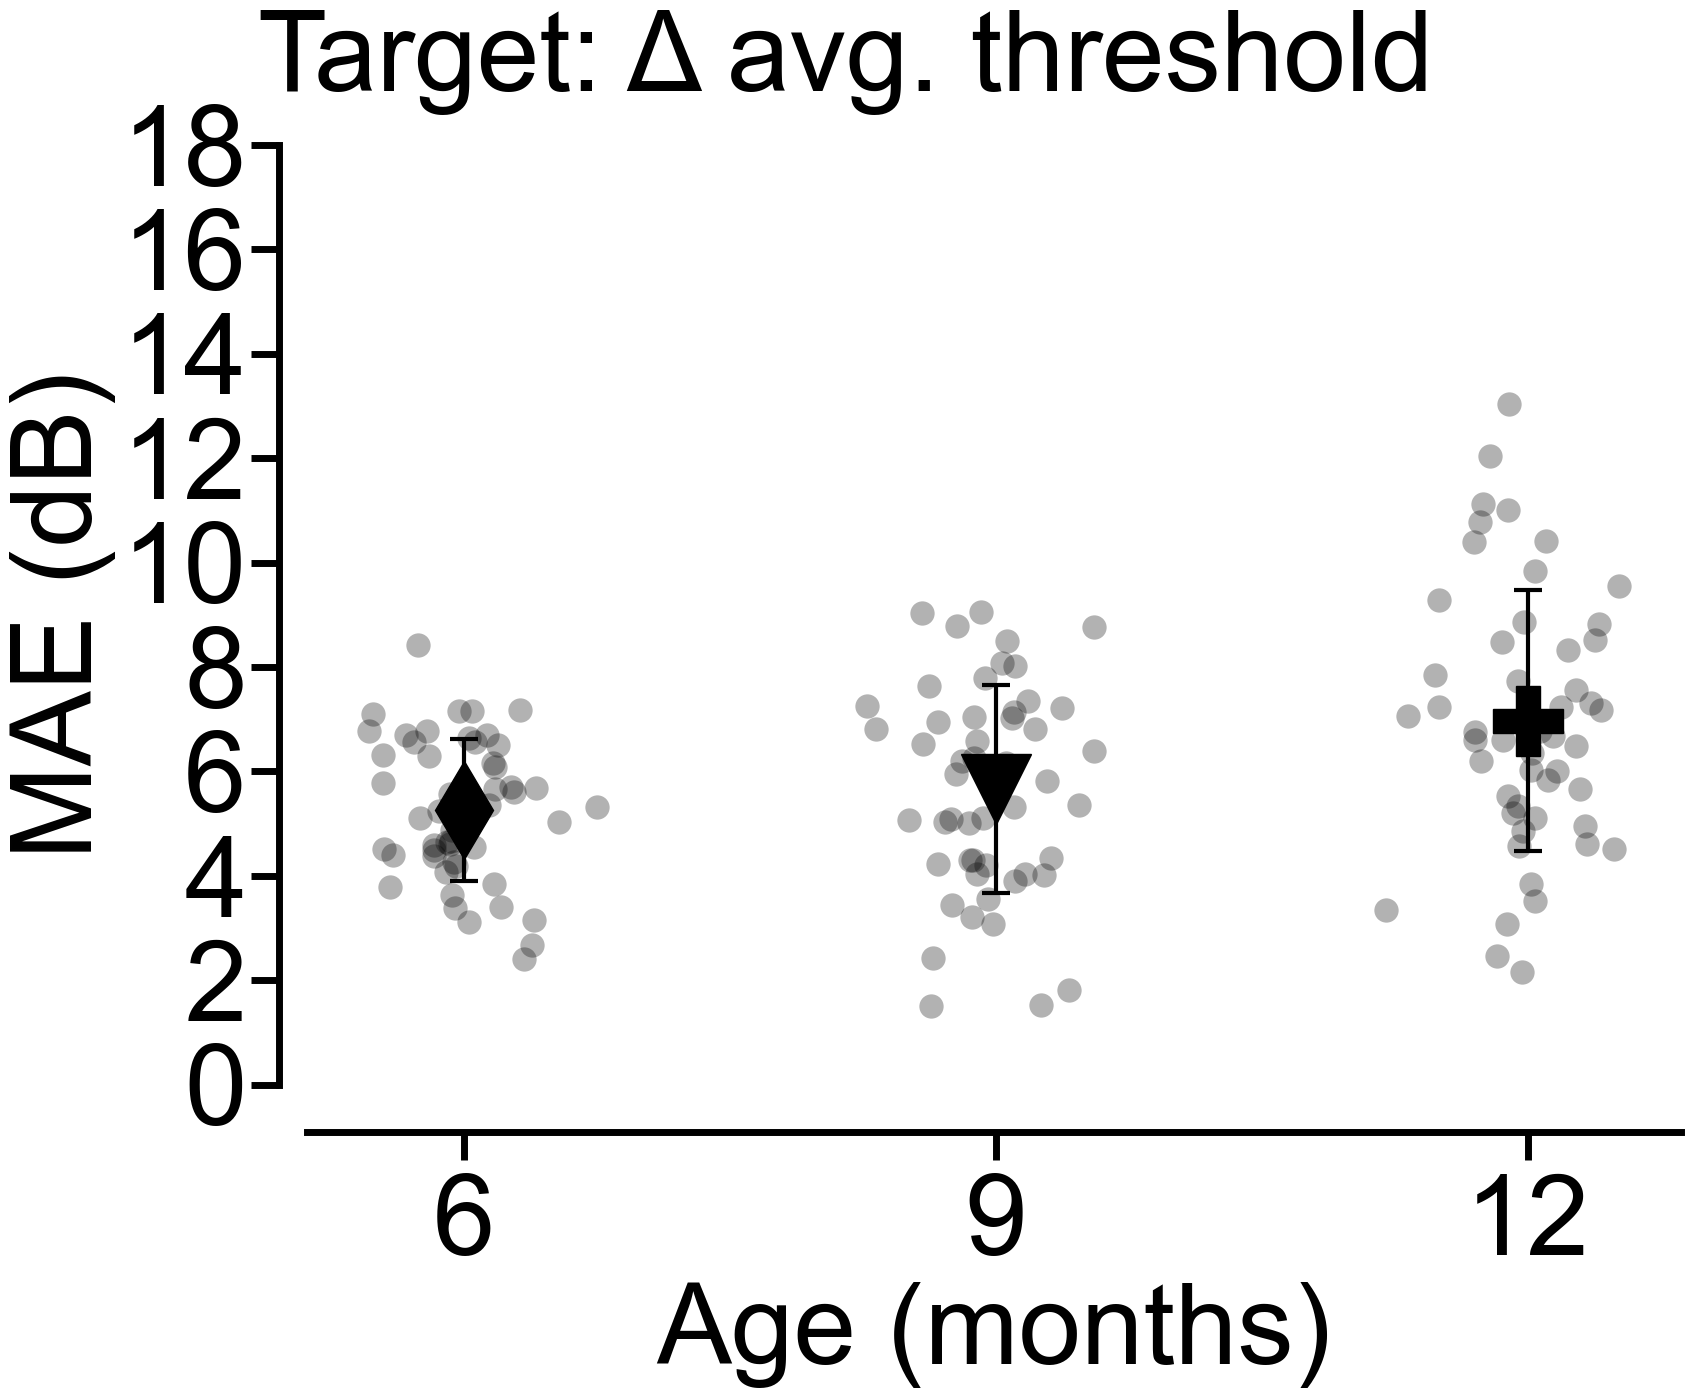

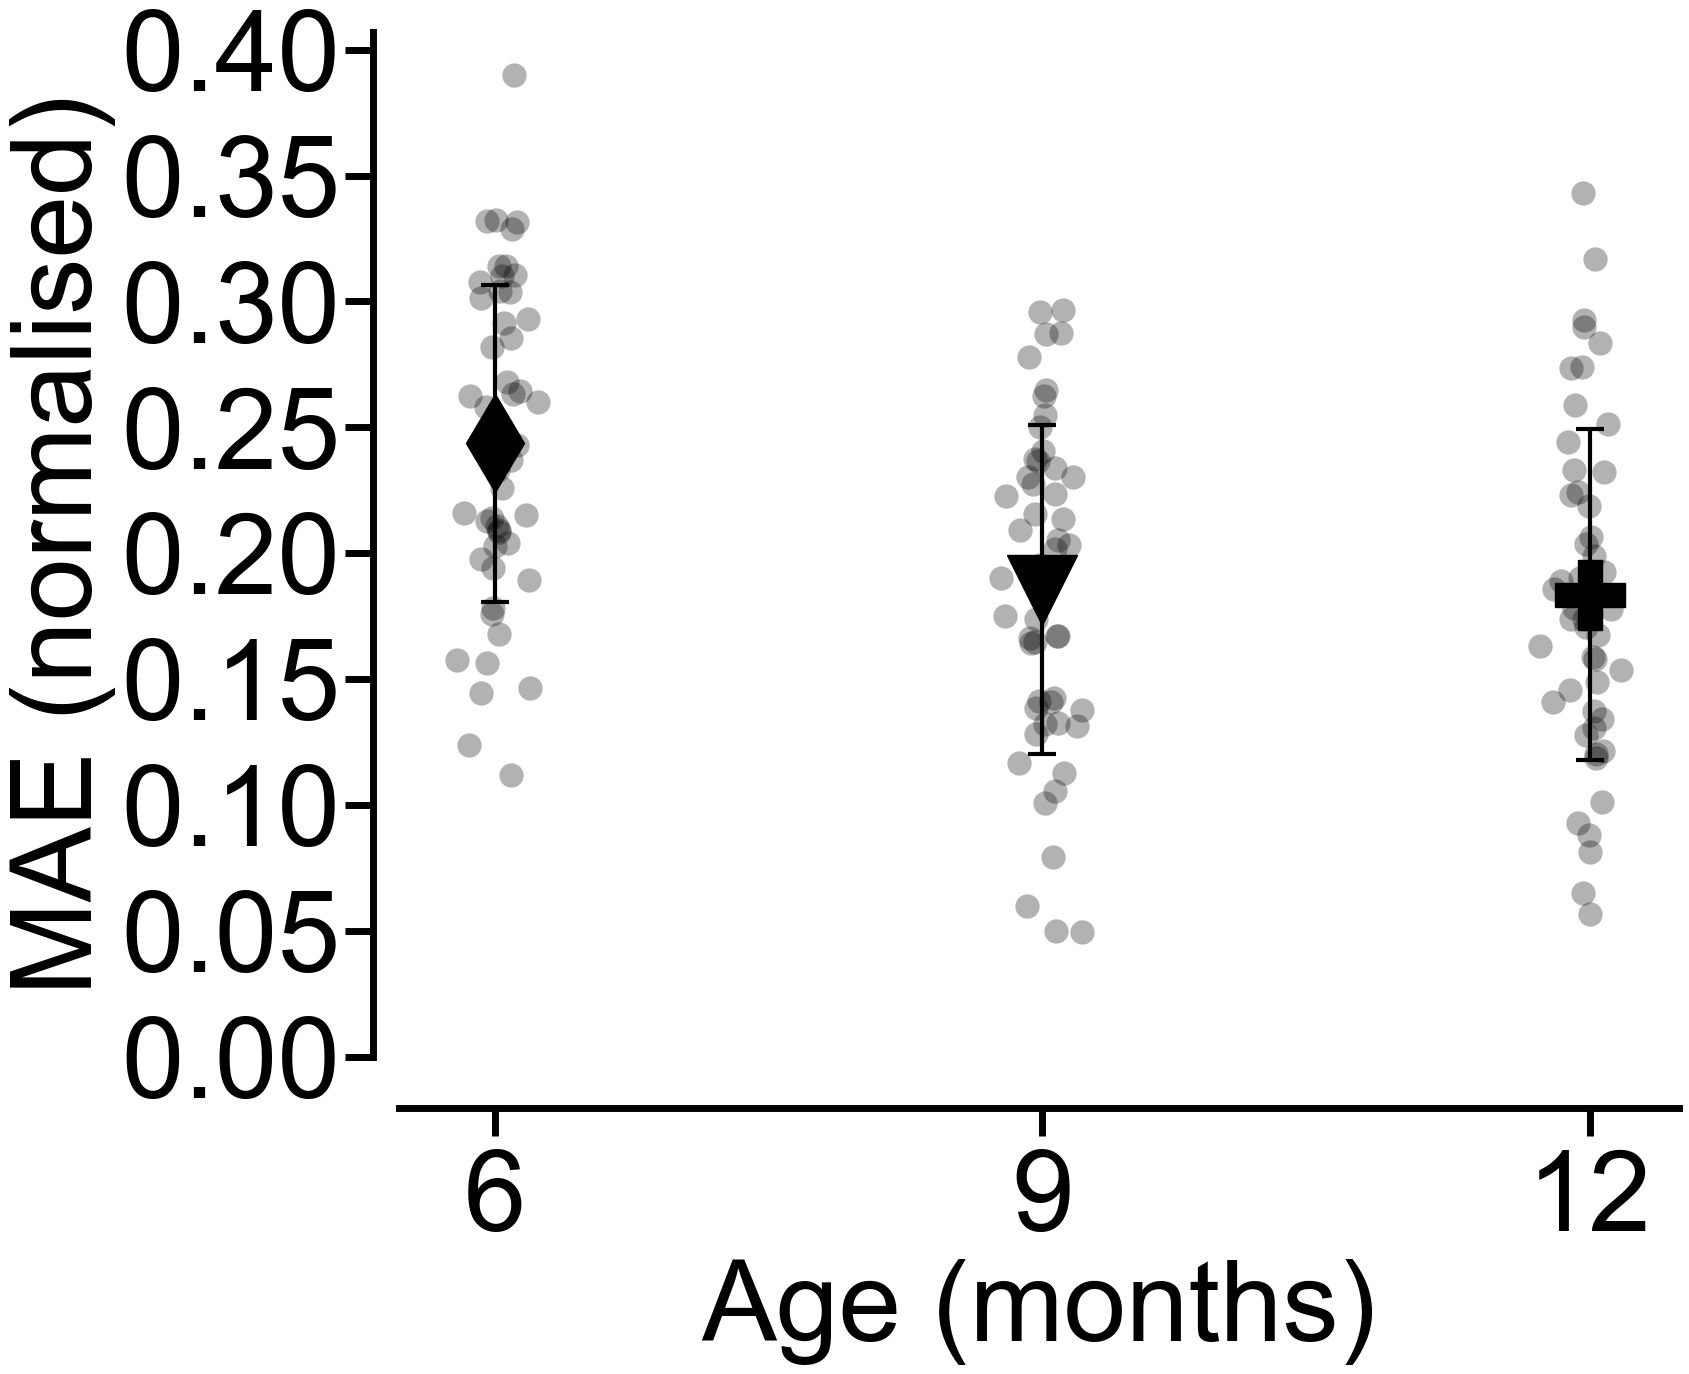

In [45]:
f,ax = makeFigureMAE(master,strain='Δ avg. threshold',variable='MAE',ylabel='MAE (dB)',colorcycle={85:'k'},
                     scatterSpread=1/10,title='Target: Δ avg. threshold')
ylim(0,18)

f.savefig('./Panels/thresholdVsAgeMAE.pdf',dpi=1200,transparent=True)

makeFigureMAE(master,strain='Δ avg. threshold',variable='MAEpercent',ylabel='MAE (normalised)',colorcycle={85:'k'})
ylim(0,)


### Average of the CV split


In [ ]:
ia = "['1month', '3month']"
masterWaveAmp.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])

In [ ]:
masterWaveLat.query('InputAge==@ia').groupby(['Intensity','Age'])[['MAE','MAEpercent']].agg([mean,std,'count'])

In [ ]:
master.query('InputAge==@ia').groupby(['Age'])[['MAE','MAEpercent']].agg([mean,std,min,max,'count'])

## 3 - Figures with results on test data

In [ ]:
def makeFigureTest(df,mouseIds,targetAges,label,colorcycle,intensities = [1],title ='',ylim=None,colorEncodeIntensity = False,figsize=(17,14),showyax = True,showxlabel=True):
    """
    Generates figures for model results on test data over time
    Parameters:
    df (DataFrame): The dataframe containing the data to plot.
    mouseIds (list): List of mouse IDs to filter the data.
    targetAges (list): List of target ages to filter the data.
    label (str): The label for the x and y axes.
    colorcycle (list): List of colors to use for plotting.
    intensities (list, optional): List of sound levels to filter the data. Default is [1].
    title (str, optional): The title of the figure. Default is an empty string.
    ylim (tuple, optional): The limits for the y-axis. Default is None.
    colorEncodeIntensity (bool, optional): Whether to color encode by intensity. Default is False.
    figsize (tuple, optional): The size of the figure. Default is (17, 14).
    showyax (bool, optional): Whether to show the y-axis. Default is True.
    showxlabel (bool, optional): Whether to show the x-axis label. Default is True.
    Returns:
    tuple: The figure and axis objects.
    """
    f= figure(figsize=figsize)
    f.suptitle(title,fontsize=fontSize,y=1)
    gs= gridspec.GridSpec(1, 1,figure=f)



    dff = df.copy()

    ax = plt.subplot(gs[0])
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.set_xlim(ylim)
        ax.plot(ylim,ylim,'--',color='grey',linewidth=3)
    
    symbols = ["d","v","P"]
    for intens in intensities:
        for i,id in enumerate(mouseIds):
                if intens==1:
                    df2 = dff.query('`Mouse ID`==@id')
                else:
                    df2 = dff.query('`Mouse ID`==@id & SoundLevel==@intens')
                if colorEncodeIntensity:
                    color = colorcycle[intens]
                else:
                    color = colorcycle[id]
                plot(df2['y_test'],df2['y_predict'],'-',
                    markersize=markersize,clip_on=False,linewidth=3,color = color)
                for j,age in enumerate(targetAges):
                    df3 = df2.query('TargetAge==@age')
                    plot(df3['y_test'],df3['y_predict'],symbols[j],markeredgecolor=color,markerfacecolor=[1,1,1,1],markeredgewidth=3,
                        markersize=markersize*0.7,clip_on=False,linewidth=3) 
#            plot(df2['Age'].apply(lambda x: {'1month':0,'3month':1,'6month':2,'9month':3,'12month':4}[x]),df2[variable].values.T,linewidth=2,alpha=0.2,label=intensity,color=colorcycle[intensity])
    
 

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_visible(True)

    ax.set_xlabel(f'Real {label}')
    ax.set_ylabel(f'Predicted {label}')
    # ax.set_xticks(arange(5),[1,3,6,9,12])
    #ax.spines['left'].set_position(('axes', -0.05))
    #ax.spines['bottom'].set_position(('axes', -0.05))
    #ax.tick_params(axis='y', which='minor', left=True)
    ax.tick_params(axis="y", direction="out", which="minor", right=False, top=False,left=True)
    ax.tick_params(axis="x", direction="out", which="minor", right=False, top=False,left=False,bottom=True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
       item.set_fontsize(fontSize)

    gs.tight_layout(f) 
    if showyax == False:
            ax.yaxis.set_visible(False)
            ax.spines.left.set_visible(False)
    if showxlabel == False:
         ax.set_xlabel(' ')
    return f,ax

In [36]:
ia = "['1month', '3month']"
targetAges = ['6month', '9month','12month']
masterTest = masterTest.query('InputAge==@ia')
mouseIds = masterTest['Mouse ID'].unique()
cmap = plt.cm.get_cmap('tab20b', len(mouseIds)).colors
cmap2 = plt.cm.get_cmap('tab20b', 3).colors
colorcycle = {}
colorcycle3 = {}
for i,mid in enumerate(mouseIds):
    colorcycle[mid] = cmap[i,:]
    colorcycle3[mid] = 'k'
colorcycle2 = dict(zip(['55dB','75dB','95dB'],plt.rcParams['axes.prop_cycle'].by_key()['color'][0:]))

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_64706/2536677170.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(mouseIds)).colors
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_64706/2536677170.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('tab20b', 3).colors


In [38]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(masterTest['y_test'],masterTest['y_predict']))
print(mean_absolute_error(masterTest['y_test'],masterTest['y_predict']))

0.6818315010175796
4.980876667217812


In [39]:
for age in targetAges:
    el = masterTest.query("TargetAge==@age")
    print(r2_score(el['y_test'],el['y_predict']))
    print(mean_absolute_error(el['y_test'],el['y_predict']))

0.6151528073445766
4.672838748346562
0.6455771638834924
5.100570987654322
0.672793393038098
5.169220265652552


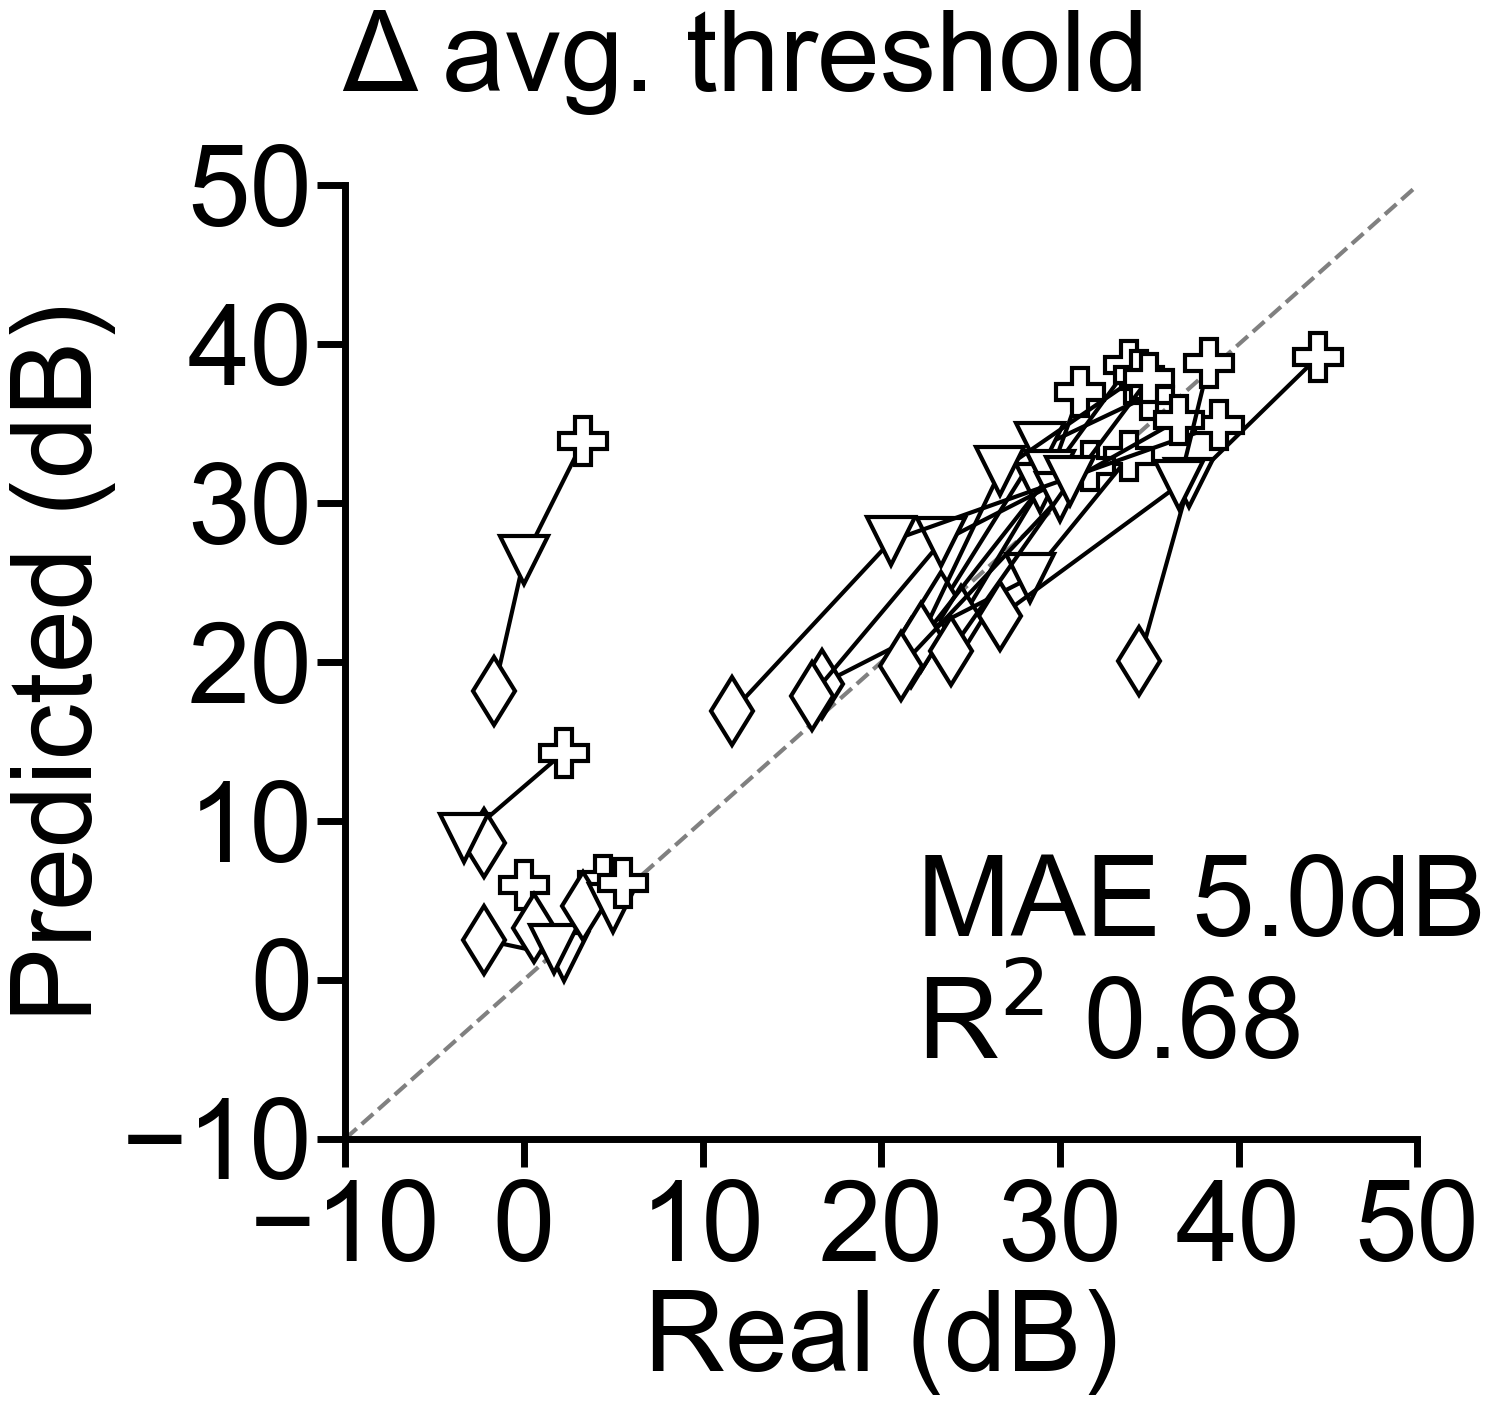

In [41]:
f,ax = makeFigureTest(masterTest,mouseIds,targetAges,'(dB)',title='Δ avg. threshold',ylim=(-10,50),colorcycle=colorcycle3,figsize=(15,14))
r2 = r2_score(masterTest['y_test'],masterTest['y_predict'])
mae= mean_absolute_error(masterTest['y_test'],masterTest['y_predict'])
ax.text(22,-5,f'MAE {mae:.1f}dB\nR$^2$ {r2:.2f}',fontsize=fontSize)


f.savefig('./Panels/thresholdVsAgeTest.pdf',dpi=1200,transparent=True)


In [42]:
ia = "['1month', '3month']"
sl = '75dB'
masterAmpTest2 = masterAmpTest.query("InputAge==@ia")

In [43]:
print("One summary for all the models combined")
from sklearn.metrics import r2_score, mean_absolute_error
print(f"R2: {r2_score(masterAmpTest2['y_test'],masterAmpTest2['y_predict'])}")
print(f"MAE: {mean_absolute_error(masterAmpTest2['y_test'],masterAmpTest2['y_predict'])}")

print("\nOne summary for one model at each intensity")
for intens in ['55dB','75dB','95dB']:

    el = masterAmpTest2.query("SoundLevel==@intens")
    print(f'{intens}')
    print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
    print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")


print("\nOne summary for one model at each intensity and at each age")
for intens in ['55dB','75dB','95dB']:
    for age in targetAges:
        print(f'{age} - {intens}')
        el = masterAmpTest2.query("TargetAge==@age & SoundLevel==@intens")
        print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
        print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")


One summary for all the models combined
R2: 0.6836249727759505
MAE: 0.808584545369606

One summary for one model at each intensity
55dB
R2: 0.6190759544277576
MAE: 0.723602896246887
75dB
R2: 0.6548504558722159
MAE: 0.8937812717899726
95dB
R2: 0.7011740992406155
MAE: 0.8083694680719584

One summary for one model at each intensity and at each age
6month - 55dB
R2: 0.3237687524488284
MAE: 0.8109929074957103
9month - 55dB
R2: 0.44696356145685
MAE: 0.7596154393864089
12month - 55dB
R2: 0.6044910268507443
MAE: 0.6002003418585417
6month - 75dB
R2: 0.5427347472876911
MAE: 0.9849645271041534
9month - 75dB
R2: 0.6014885698460729
MAE: 0.8663078182411084
12month - 75dB
R2: 0.6151950606942059
MAE: 0.8300714700246561
6month - 95dB
R2: 0.7479861352980572
MAE: 0.6715069307362598
9month - 95dB
R2: 0.7095580403772752
MAE: 0.7404793200209245
12month - 95dB
R2: 0.5594250649783548
MAE: 1.0131221534586907


(<Figure size 1700x1400 with 1 Axes>,
 <Axes: xlabel='Real (μV)', ylabel='Predicted (μV)'>)

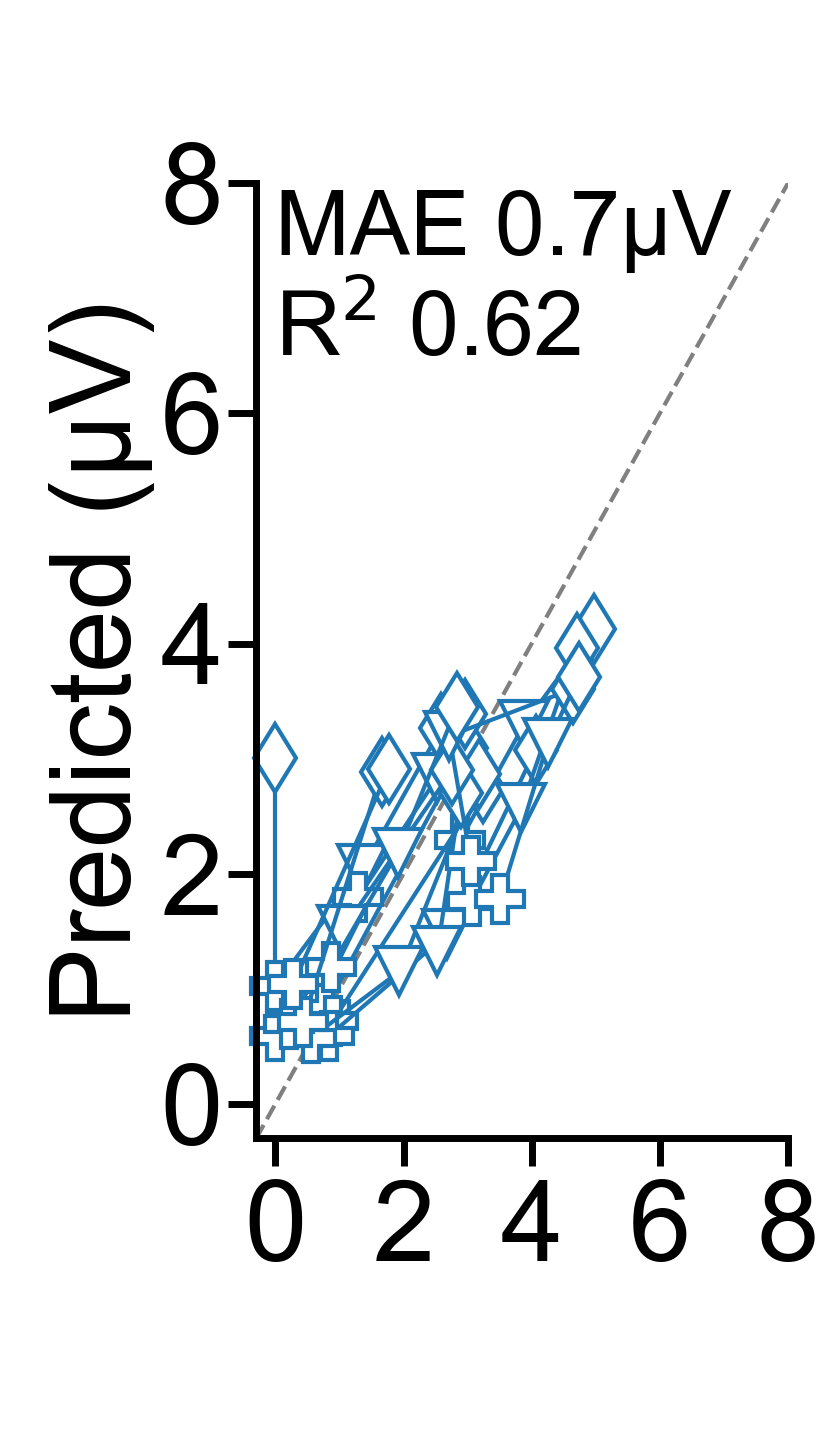

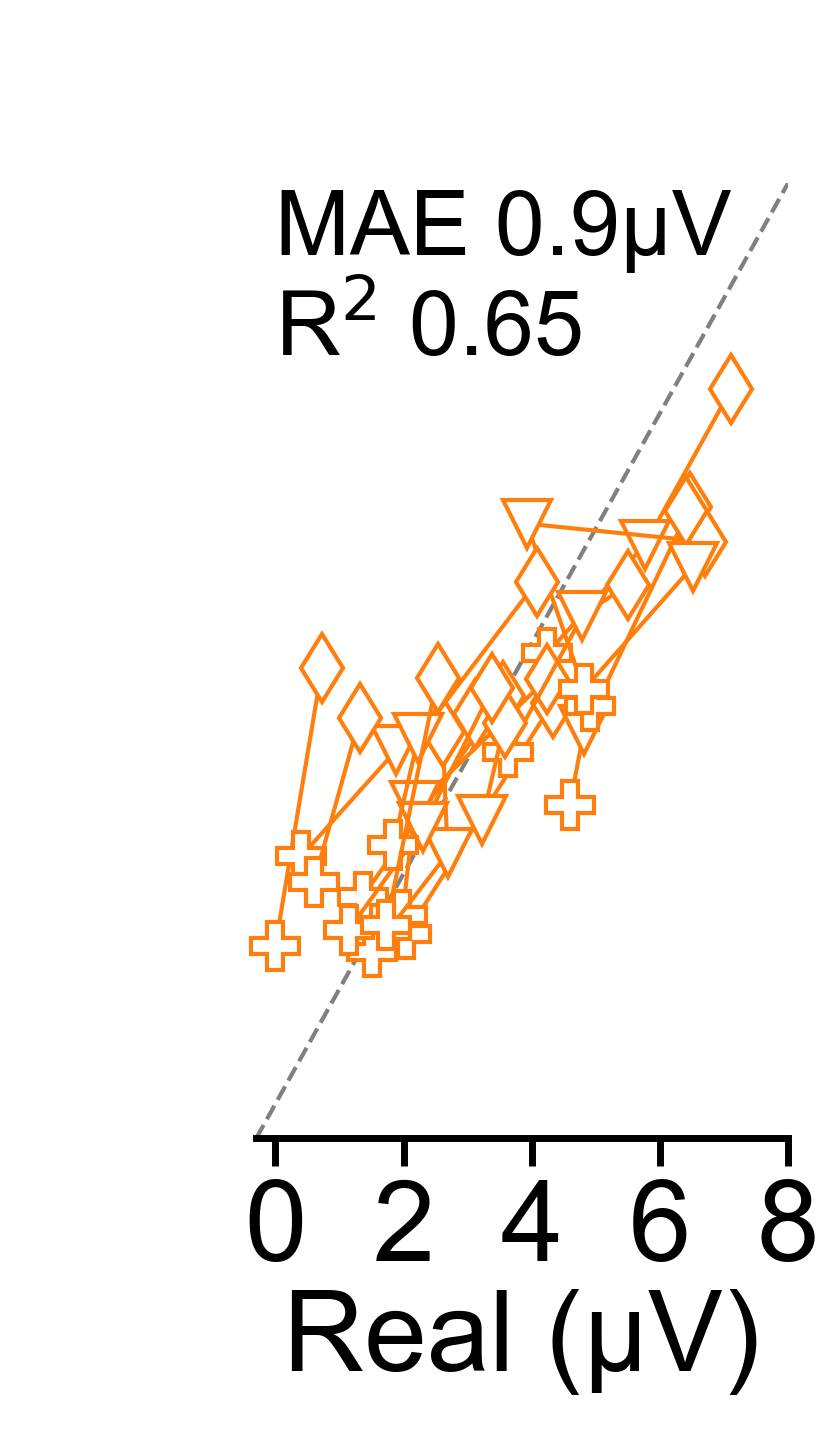

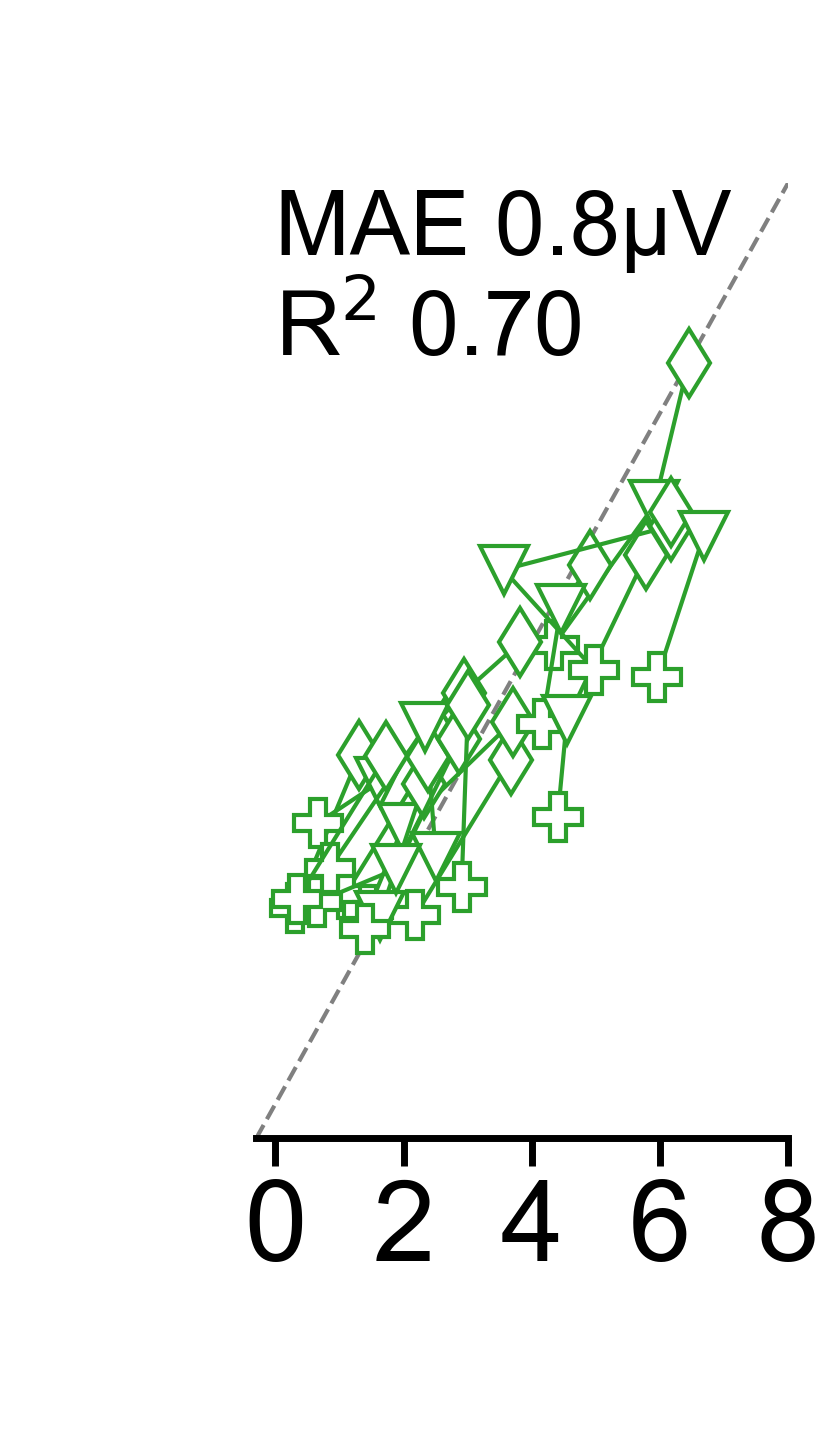

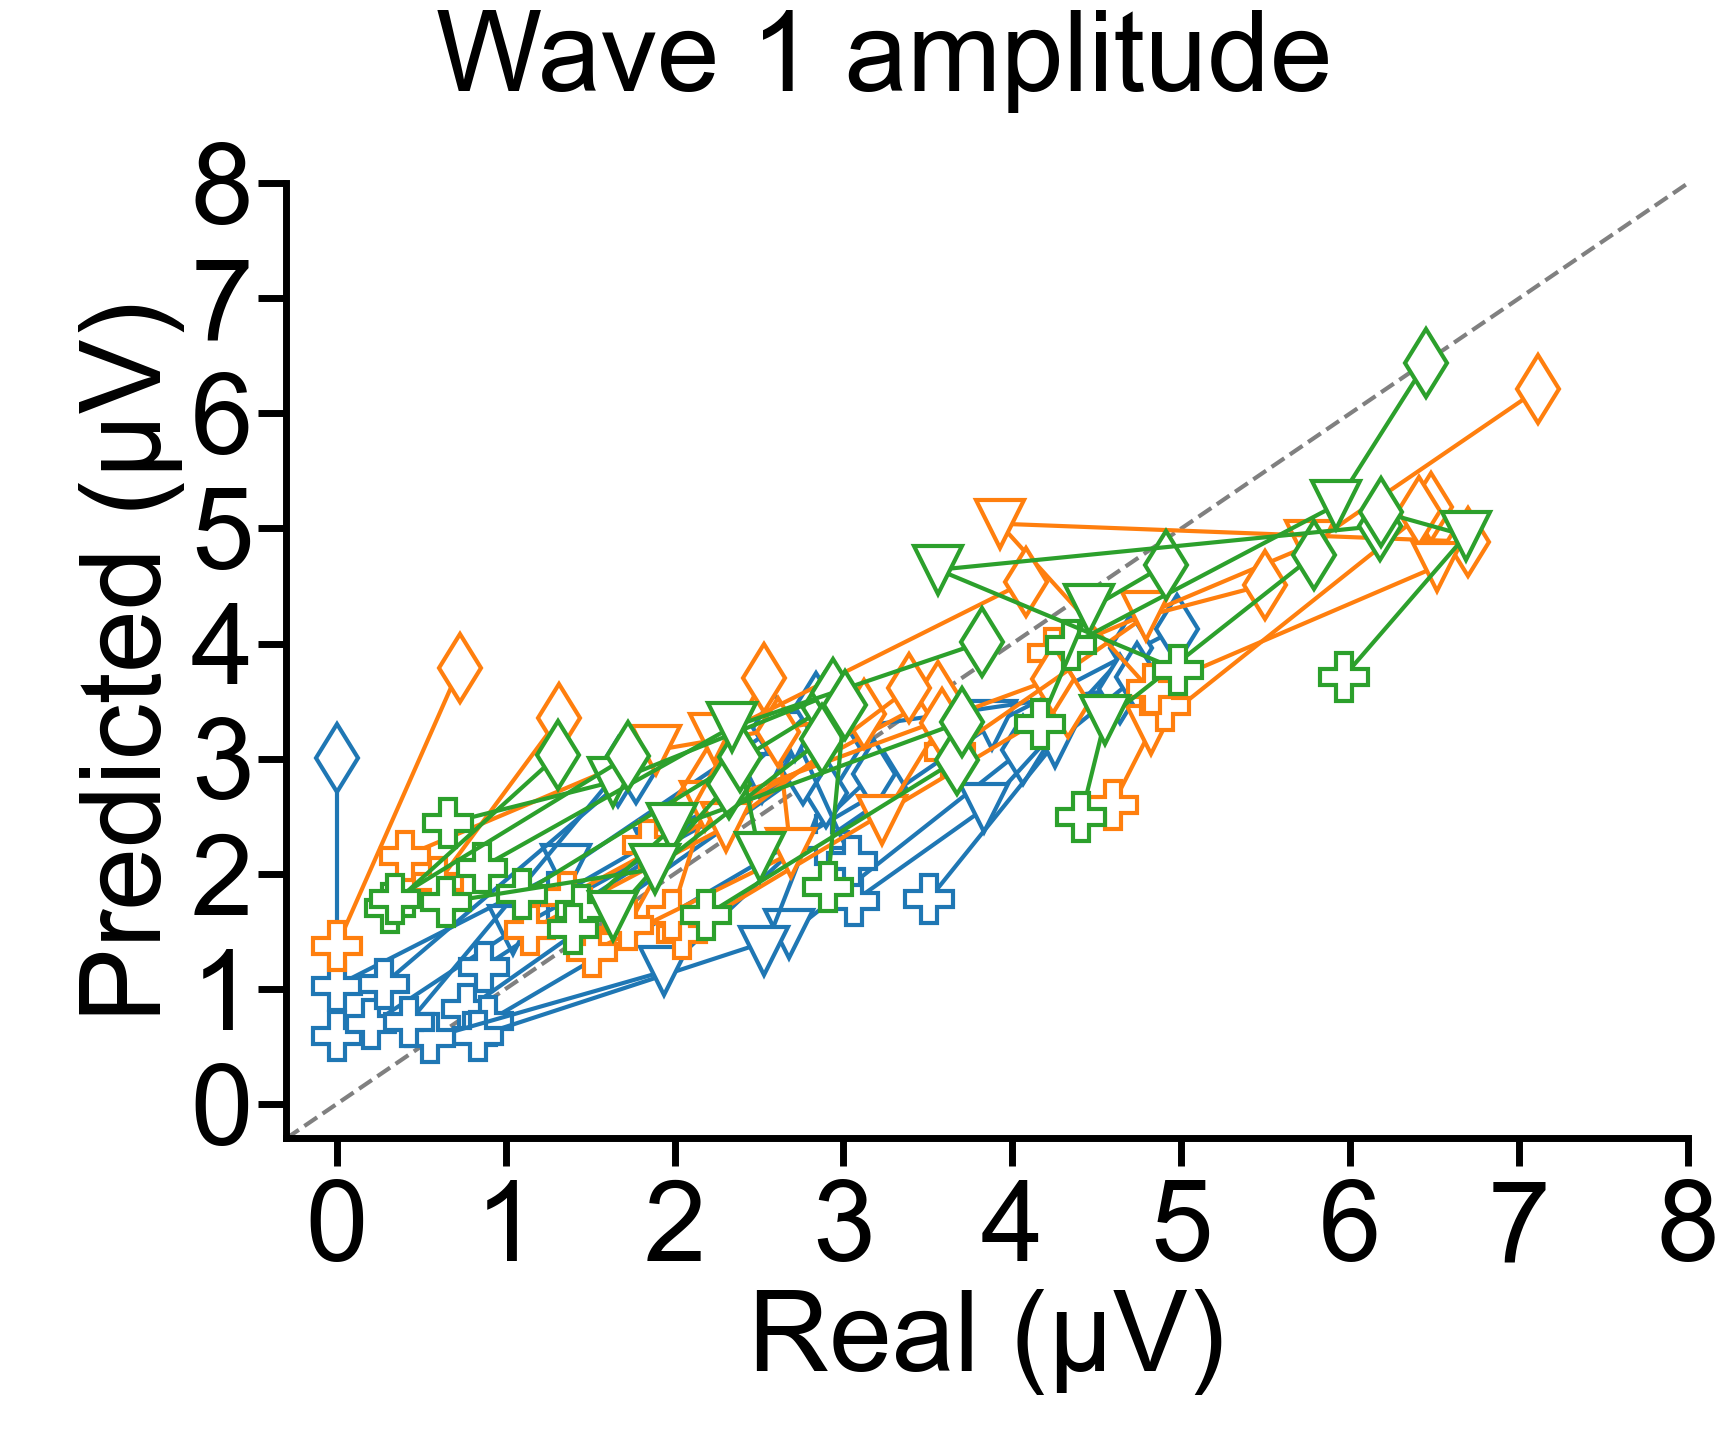

In [44]:
for intens in ['55dB','75dB','95dB']:
    showy = False if intens!='55dB' else True
    showxlabel = False if intens!='75dB' else True
    f,ax = makeFigureTest(masterAmpTest2,mouseIds,targetAges,'(μV)',intensities=[intens],title=' ',ylim=(-0.3,8),colorcycle=colorcycle2,
                          colorEncodeIntensity=True,figsize=(8,14),showyax=showy,showxlabel = showxlabel)
    ax.set_xticks(arange(0,8.1,2))
    ax.set_yticks(arange(0,8.1,2))
    
    el = masterAmpTest2.query("SoundLevel==@intens")
    r2 = r2_score(el['y_test'],el['y_predict'])
    mae= mean_absolute_error(el['y_test'],el['y_predict'])
    ax.text(0,6.5,f'MAE {mae:.1f}μV\nR$^2$ {r2:.2f}',fontsize=fontSize*0.8)


    f.savefig(f'./Panels/ampVsAgeTest{intens}.pdf',dpi=1200,transparent=True)
makeFigureTest(masterAmpTest.query("InputAge==@ia"),mouseIds,targetAges,'(μV)',intensities=['55dB','75dB','95dB'],title='Wave 1 amplitude',ylim=(-0.3,8),colorcycle=colorcycle2,colorEncodeIntensity=True)

In [45]:
ia = "['1month', '3month']"
masterLatTest2 = masterLatTest.query("InputAge==@ia")

In [46]:
print("One summary for all the models combined")
from sklearn.metrics import r2_score, mean_absolute_error
print(f"R2: {r2_score(masterLatTest2['y_test'],masterLatTest2['y_predict'])}")
print(f"MAE: {mean_absolute_error(masterLatTest2['y_test'],masterLatTest2['y_predict'])}")

print("\nOne summary for one model at each intensity")
for intens in ['55dB','75dB','95dB']:

    el = masterLatTest2.query("SoundLevel==@intens")
    print(f'{intens}')
    print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
    print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")


print("\nOne summary for one model at each intensity and at each age")
for intens in ['55dB','75dB','95dB']:
    for age in targetAges:
        print(f'{age} - {intens}')
        el = masterLatTest2.query("TargetAge==@age & SoundLevel==@intens")
        print(f"R2: {r2_score(el['y_test'],el['y_predict'])}")
        print(f"MAE: {mean_absolute_error(el['y_test'],el['y_predict'])}")

One summary for all the models combined
R2: 0.7900694510937796
MAE: 0.07301666046145204

One summary for one model at each intensity
55dB
R2: 0.6859412834312675
MAE: 0.09158846512284008
75dB
R2: 0.6079716599913098
MAE: 0.07417078816245483
95dB
R2: 0.6223239824260477
MAE: 0.05329072809906125

One summary for one model at each intensity and at each age
6month - 55dB
R2: 0.5610656782313497
MAE: 0.062189599867724696
9month - 55dB
R2: 0.5693162157664455
MAE: 0.10678704397454383
12month - 55dB
R2: 0.6802851775137013
MAE: 0.10578875152625171
6month - 75dB
R2: 0.2189612412431039
MAE: 0.06969190832315832
9month - 75dB
R2: 0.5772403603721018
MAE: 0.06976652225089719
12month - 75dB
R2: 0.6356922749257714
MAE: 0.08305393391330897
6month - 95dB
R2: 0.07239021347229735
MAE: 0.03651695538258032
9month - 95dB
R2: 0.43326487858299534
MAE: 0.04768360805860784
12month - 95dB
R2: 0.5609257735565829
MAE: 0.07567162085599559


(<Figure size 1700x1400 with 1 Axes>,
 <Axes: xlabel='Real (ms)', ylabel='Predicted (ms)'>)

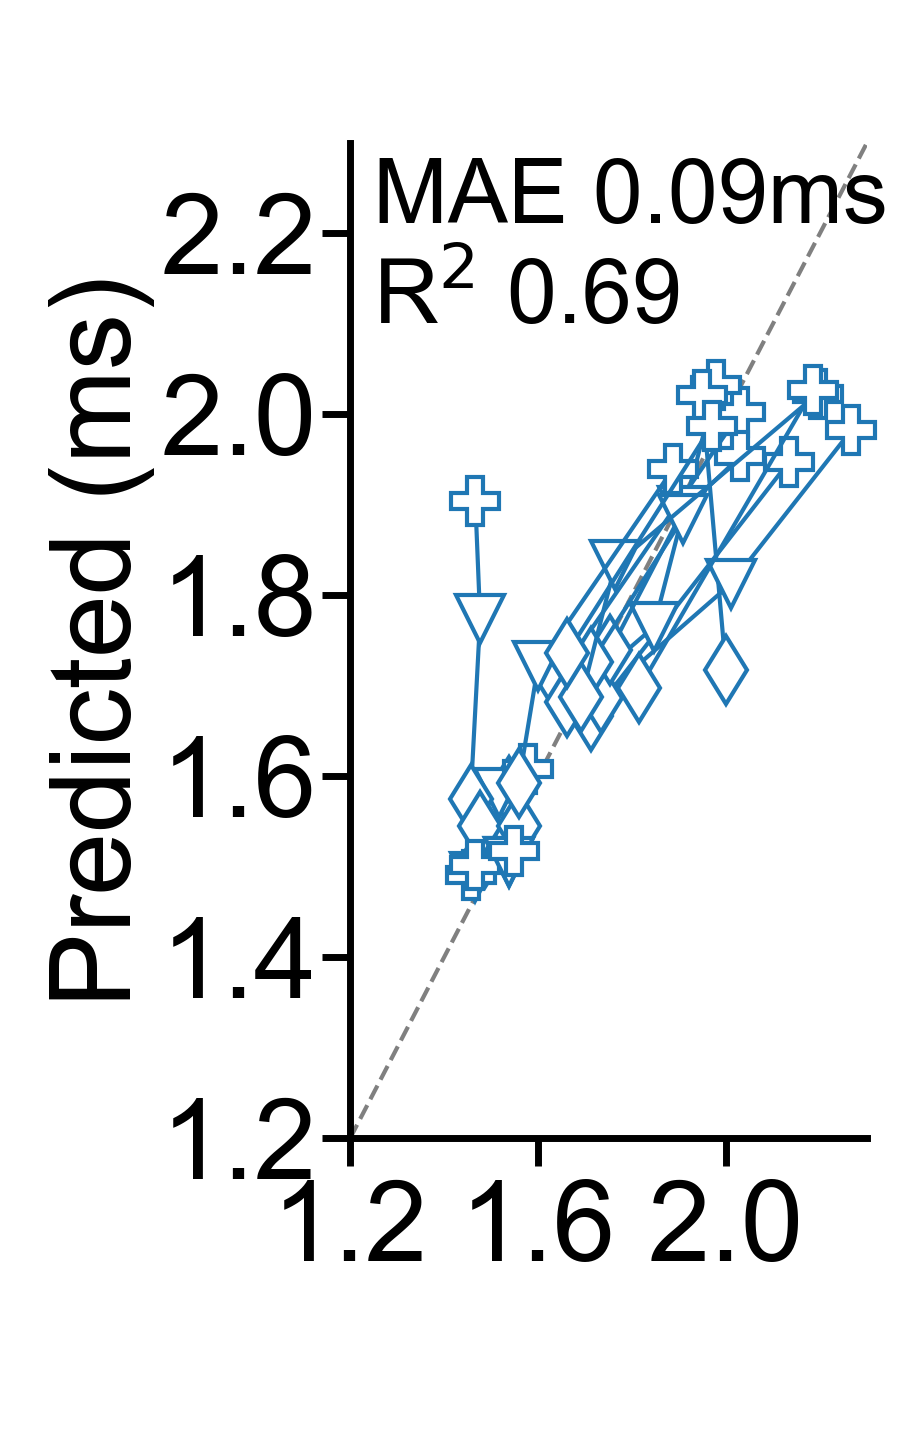

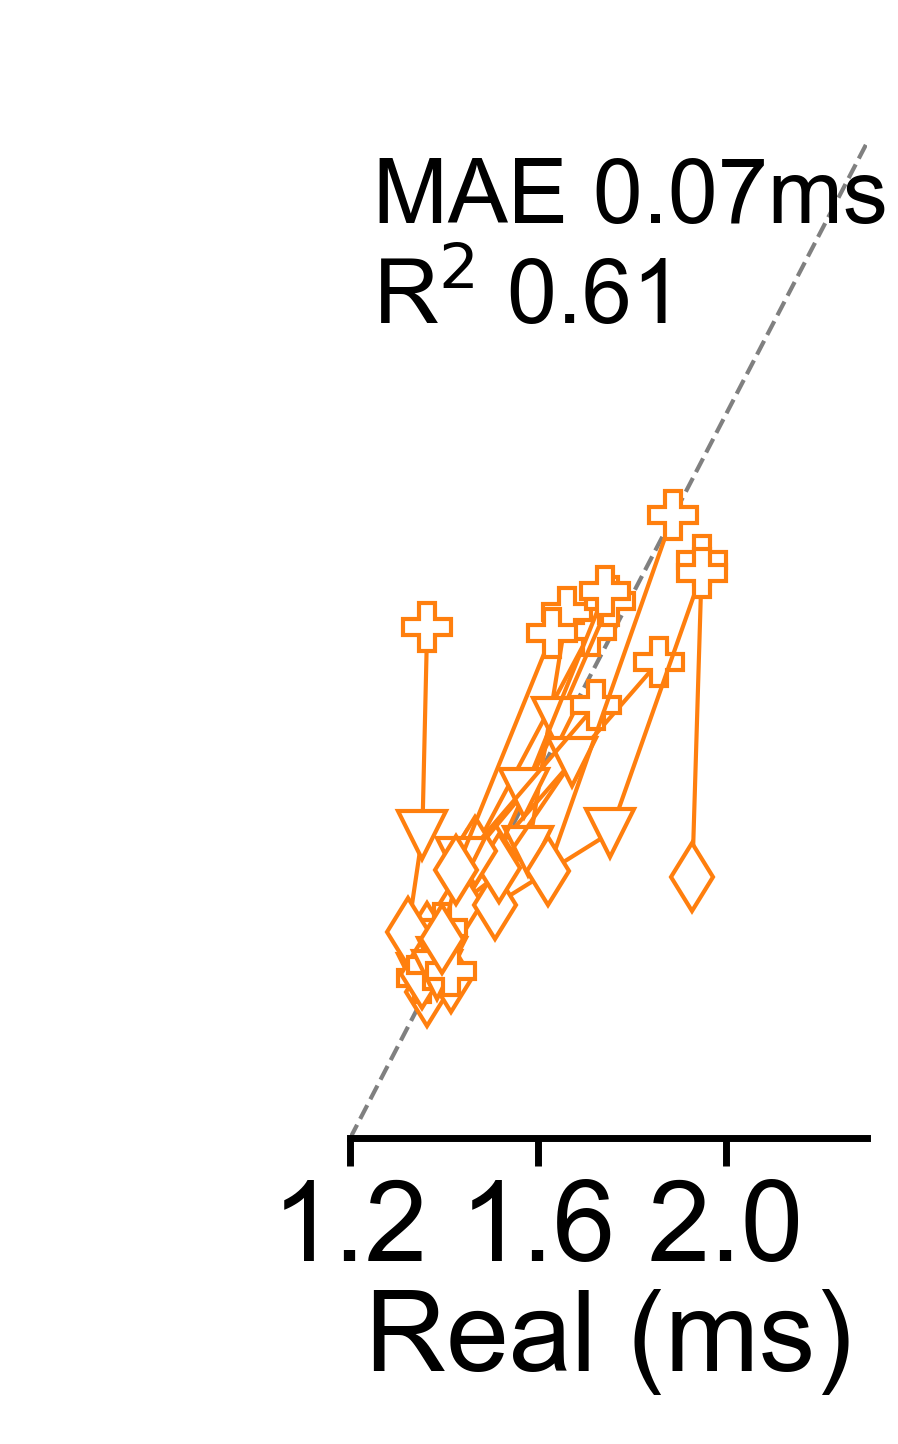

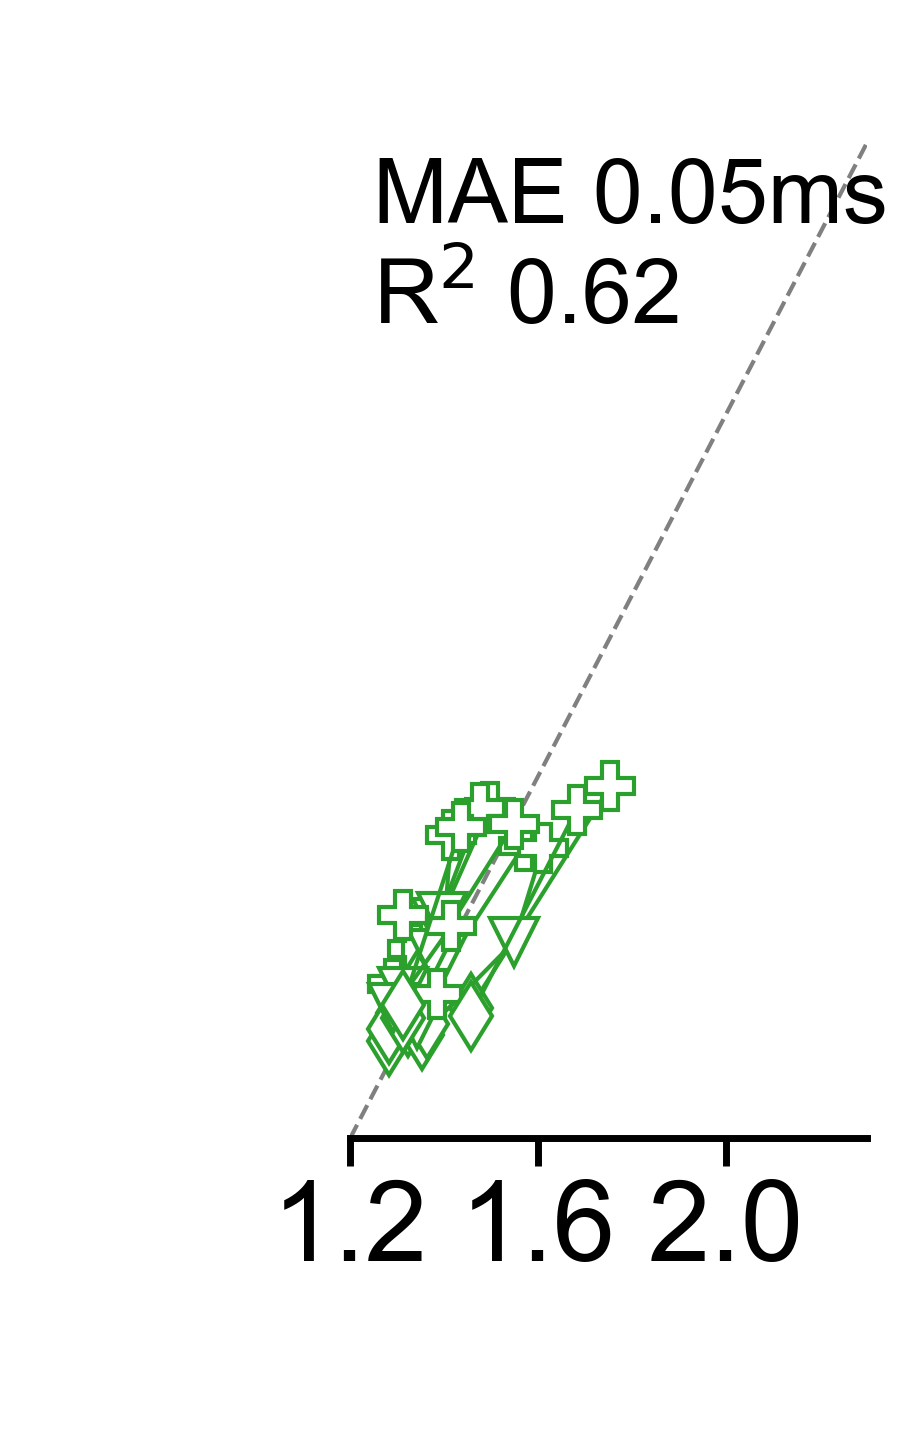

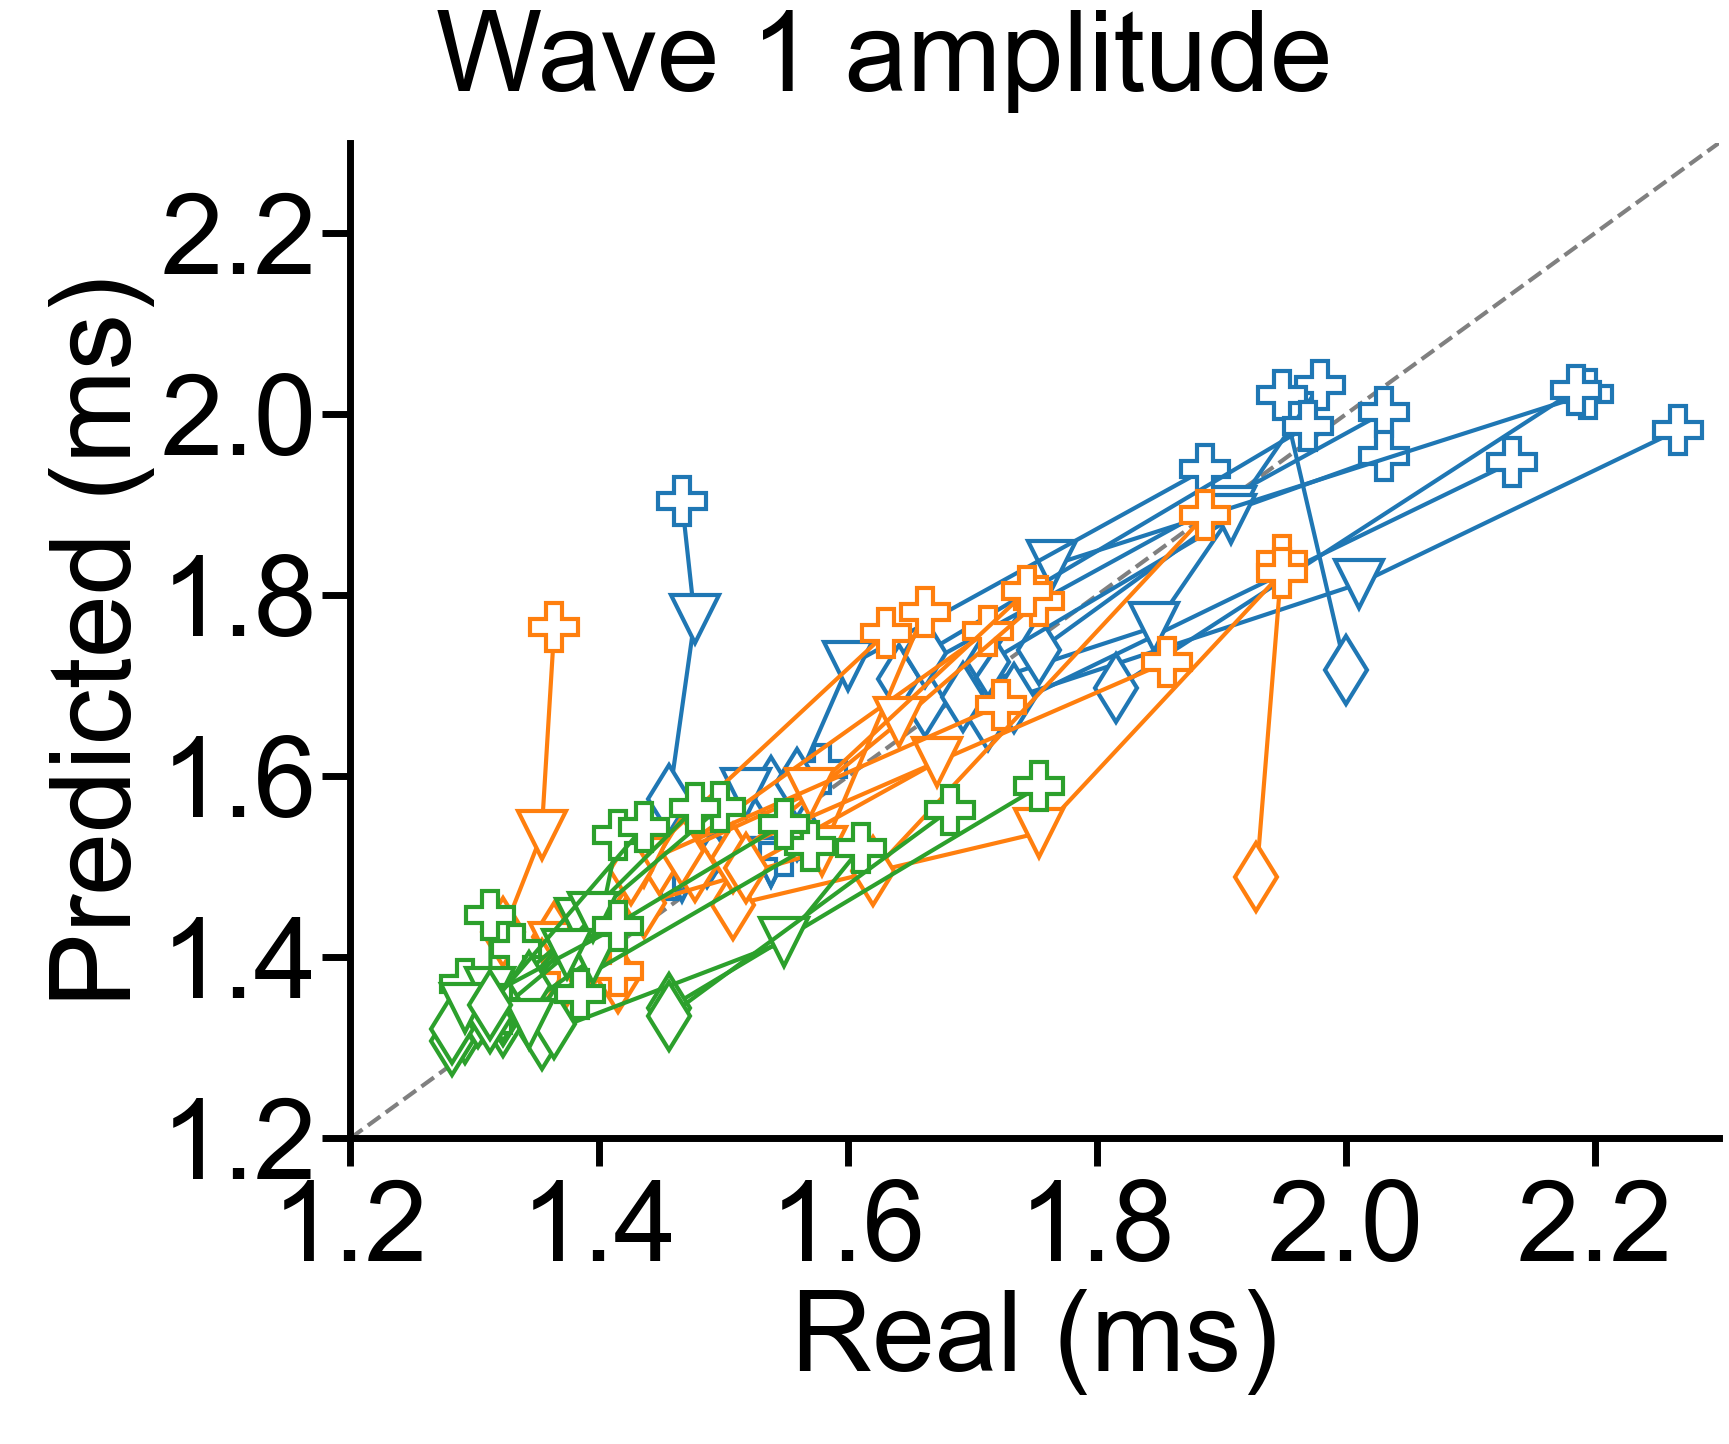

In [47]:


for intens in ['55dB','75dB','95dB']:
    showy = False if intens!='55dB' else True
    showxlabel = False if intens!='75dB' else True
    f,ax = makeFigureTest(masterLatTest2,mouseIds,targetAges,'(ms)',intensities=[intens],title=' ',ylim=(1.2,2.3),colorcycle=colorcycle2,
                          colorEncodeIntensity=True,figsize=(8.65,14),showyax=showy,showxlabel = showxlabel)
    ax.set_xticks(arange(1.2,2.3,0.4))
    
    el = masterLatTest2.query("SoundLevel==@intens")
    r2 = r2_score(el['y_test'],el['y_predict'])
    mae= mean_absolute_error(el['y_test'],el['y_predict'])
    ax.text(1.25,2.1,f'MAE {mae:.2f}ms\nR$^2$ {r2:.2f}',fontsize=fontSize*0.8,clip_on=False)

    f.savefig(f'./Panels/latVsAgeTest{intens}.pdf',dpi=1200,transparent=True)


makeFigureTest(masterLatTest.query("InputAge==@ia"),mouseIds,targetAges,'(ms)',intensities=['55dB','75dB','95dB'],ylim=(1.2,2.3),title='Wave 1 amplitude',colorcycle=colorcycle2,colorEncodeIntensity=True)

In [49]:
# Create custom legends

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_64706/2911792169.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  tight_layout()


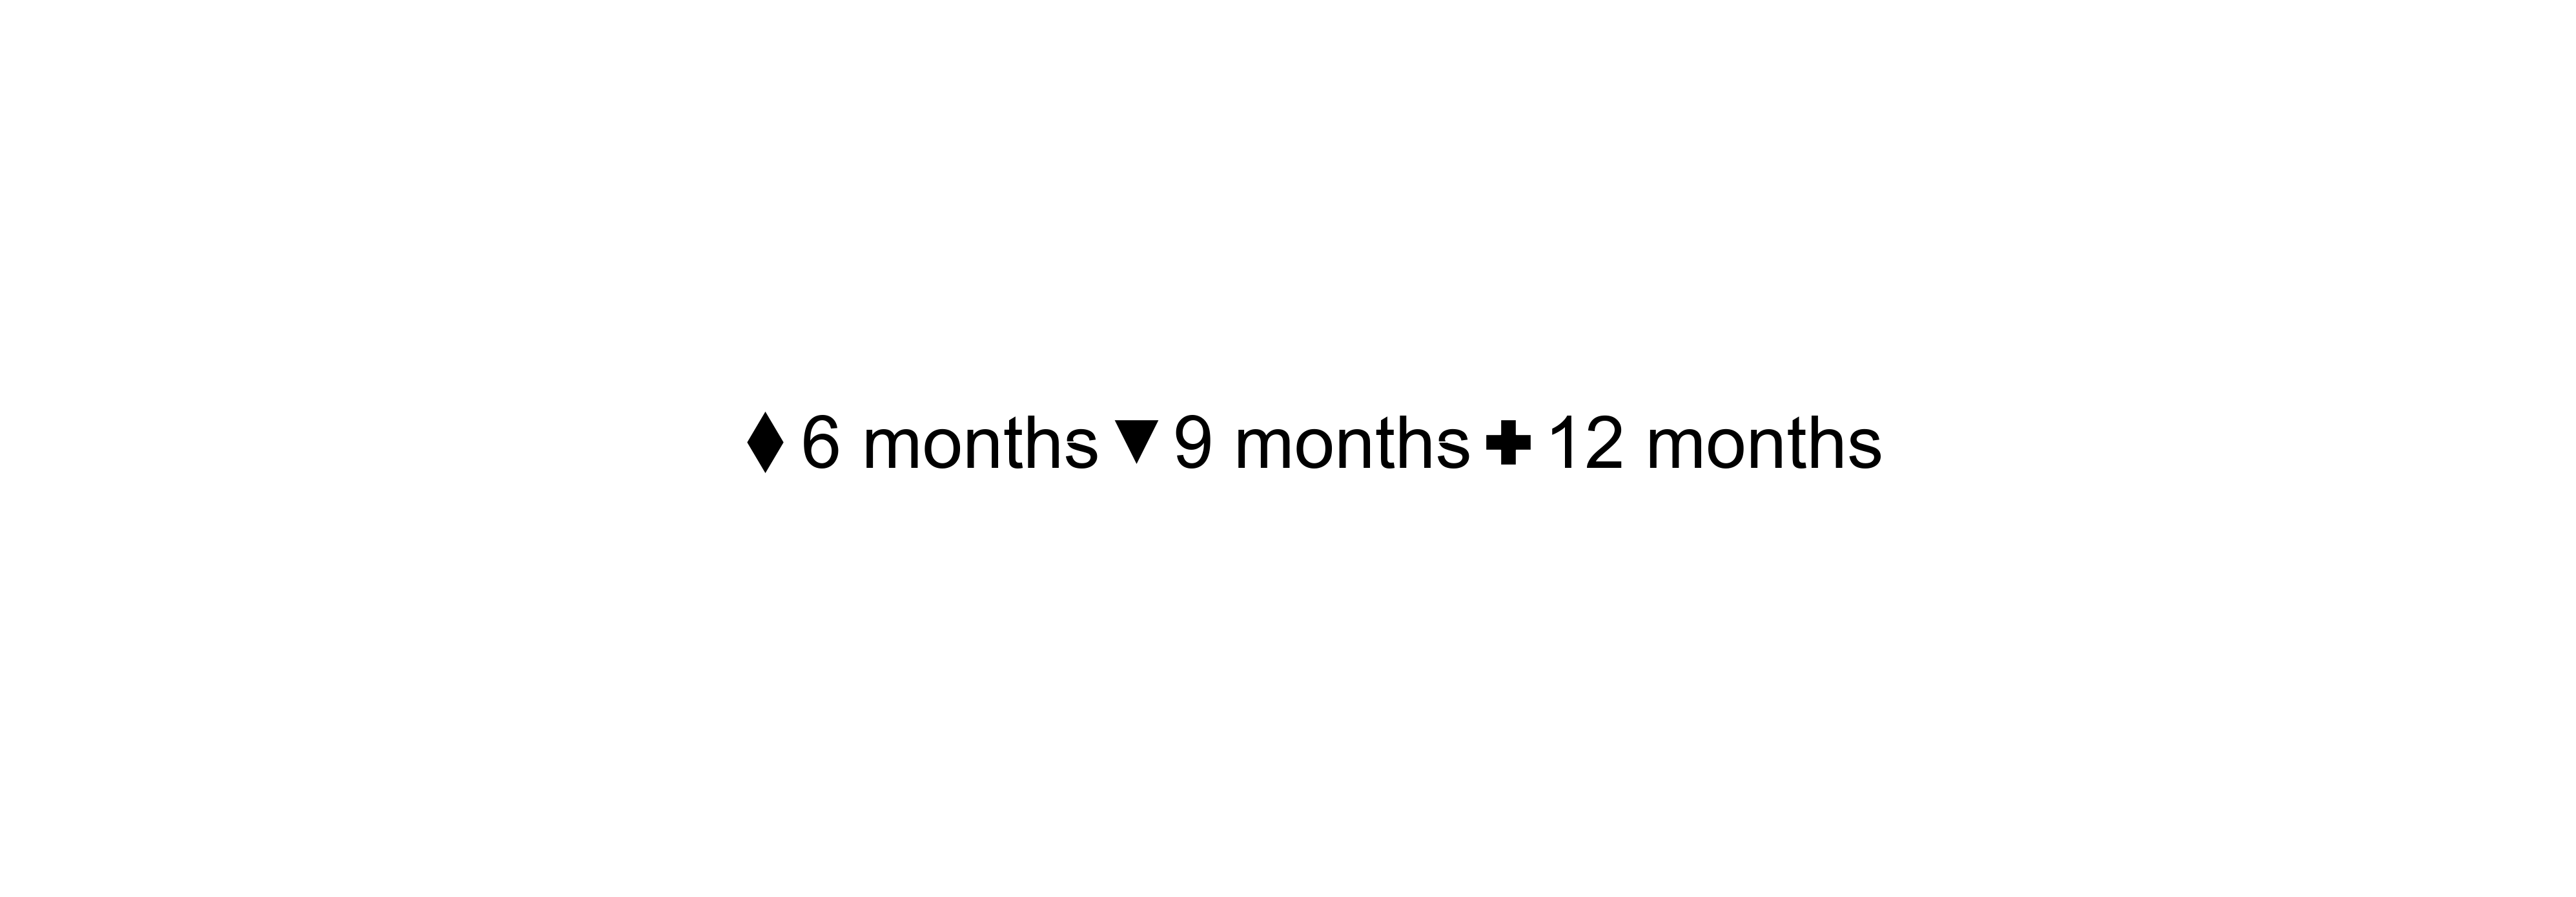

In [50]:

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [
                   Line2D([0], [0], marker='d', color='w', label='6 months',
                          markerfacecolor='k', markersize=markersize),
                     Line2D([0], [0], marker='v', color='w', label='9 months',
                            markerfacecolor='k', markersize=markersize),
                     Line2D([0], [0], marker='P', color='w', label='12 months',
                            markerfacecolor='k', markersize=markersize),
                   ]

# Create the figure
f= figure(figsize=(40,14))
gs= gridspec.GridSpec(1, 1,figure=f)

ax = plt.subplot(gs[0])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

ax.legend(handles=legend_elements, fontsize=fontSize,loc='center',ncol=3,frameon=False,
          mode=None,columnspacing=-.5,handletextpad = -0.5)
gs.tight_layout(f) 
tight_layout()
savefig('./Panels/Figure8Lenged.pdf',transparent=True,dpi=1200)

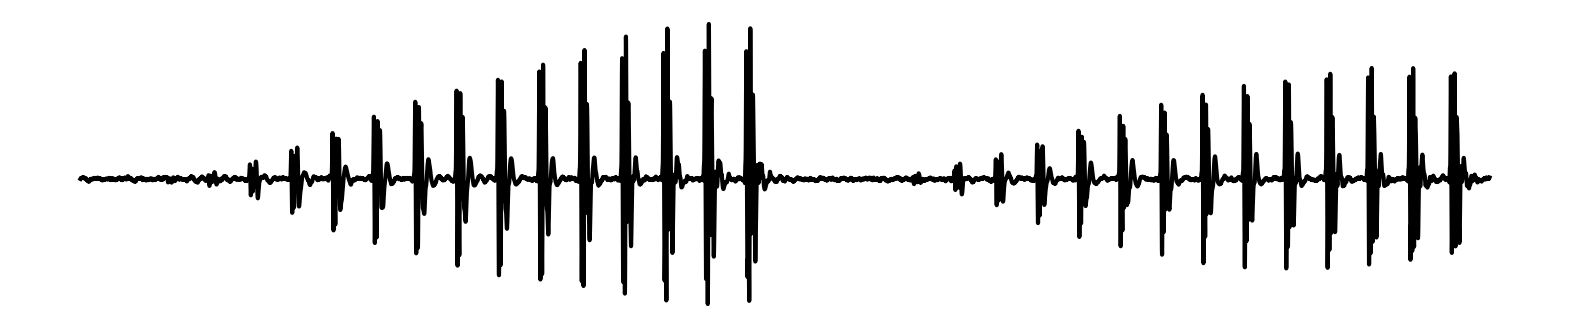

In [ ]:
#Create sample plot of the used features
import abrTools as at 
X_train,  X_test,y_train,y_test,mouseIDtrain,mouseIDtest,mouseStrainTrain,mouseStrainTest,dataVersion = at.createFutureThresholdDataset(datafolder ='../../data',test_size=0.25,inputFreqs=[100],inputs = ['1month','3month'] ,
                                                                                                                                        strains = ['6N','Repaired'],target = '6month',mode = 'waveamp',
              
f= figure(figsize=(20,4))

plot(X_train.mean(0),'k',linewidth=3)
ax = gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
f.savefig('./Panels/regressiontrace.pdf',dpi=1200,transparent=True)